In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns             

sns.set_style("darkgrid")
sys.path.append('/home/robot-i9/Anand/')
print(sys.path)

from NeuralBlocks.models.densenet import DenseNet

['/home/robot-i9/Anand/NeuralBlocks/notebooks', '/home/robot-i9/miniconda3/envs/main/lib/python37.zip', '/home/robot-i9/miniconda3/envs/main/lib/python3.7', '/home/robot-i9/miniconda3/envs/main/lib/python3.7/lib-dynload', '', '/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages', '/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/extensions', '/home/robot-i9/.ipython', '/home/robot-i9/Anand/']


In [6]:
torch.manual_seed(2456)
cudnn.deterministic = True
cudnn.benchmark = False
np.random.seed(2456)

NUM_EPOCH = 200
BATCH_SIZE = 128
CHECKPOINT_INTERVAL = 100
LRS = [0.0001, 0.001, 0.01]
NORMS =[None,'BN', 'SN', 'WN', 'MSN', 'MSNTReLU', 'WNTReLU']
DATA_PATH = "/home/robot-i9/Anand/NeuralBlocks/data_utils/datasets/CIFAR10/"
SAVE_PATH = "/home/robot-i9/Anand/NeuralBlocks/experiments/CIFAR10/"

os.makedirs(SAVE_PATH, exist_ok=True)

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        train_loss_log.append(train_loss/(batch_idx+1))
        train_acc_log.append( 100.*correct/total)
        
        if(batch_idx%CHECKPOINT_INTERVAL==0):
             print("Train Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(trainloader),
                train_loss/(batch_idx+1), 100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            test_loss_log.append(test_loss/(batch_idx+1))
            test_acc_log.append( 100.*correct/total)
        
            if(batch_idx%CHECKPOINT_INTERVAL==0):
                print("Test Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(testloader),
                test_loss/(batch_idx+1), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(SAVE_PATH+'checkpoint'):
            os.mkdir(SAVE_PATH+'checkpoint')
        torch.save(state, SAVE_PATH+'checkpoint/ckpt.pth')
        best_acc = acc

In [12]:
best_acc = 0 
# lr = 0.001
for lr in tqdm_notebook(LRS):
    for norm in tqdm_notebook(NORMS):
        net = DenseNet(3, 10, norm=norm).cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=lr)

        train_loss_log =[]
        train_acc_log = []
        test_loss_log =[]
        test_acc_log =[]

        for epoch in tqdm_notebook(range(NUM_EPOCH)):
            train(epoch)
            test(epoch)

        np.save(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr), train_loss_log)  
        np.save(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr), test_loss_log)    
        np.save(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr), train_acc_log)    
        np.save(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr), test_acc_log)   
        del net

Train Epoch [  0/200]Batch [  0/391] Loss: 2.315 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 2.185 Acc 21.558%
Train Epoch [  0/200]Batch [200/391] Loss: 2.101 Acc 24.895%
Train Epoch [  0/200]Batch [300/391] Loss: 2.038 Acc 27.359%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.731 Acc 46.875%
Saving..
Train Epoch [  1/200]Batch [  0/391] Loss: 1.848 Acc 32.031%
Train Epoch [  1/200]Batch [100/391] Loss: 1.780 Acc 37.214%
Train Epoch [  1/200]Batch [200/391] Loss: 1.758 Acc 37.982%
Train Epoch [  1/200]Batch [300/391] Loss: 1.741 Acc 38.434%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.549 Acc 50.000%
Saving..
Train Epoch [  2/200]Batch [  0/391] Loss: 1.624 Acc 46.094%
Train Epoch [  2/200]Batch [100/391] Loss: 1.654 Acc 41.275%
Train Epoch [  2/200]Batch [200/391] Loss: 1.644 Acc 41.348%
Train Epoch [  2/200]Batch [300/391] Loss: 1.636 Acc 41.770%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.493 Acc 53.906%
Saving..
Train Epoch [  3/200]Batch [  0/391] Loss: 1.501 Acc 39.062%
T

Train Epoch [ 26/200]Batch [200/391] Loss: 1.258 Acc 56.817%
Train Epoch [ 26/200]Batch [300/391] Loss: 1.260 Acc 56.756%
Test Epoch [ 26/200]Batch [  0/ 79] Loss: 1.125 Acc 64.844%
Saving..
Train Epoch [ 27/200]Batch [  0/391] Loss: 1.192 Acc 59.375%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.256 Acc 56.946%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.256 Acc 56.693%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.257 Acc 56.689%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.140 Acc 61.719%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.265 Acc 52.344%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.263 Acc 56.745%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.260 Acc 56.732%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.257 Acc 56.876%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.111 Acc 64.062%
Saving..
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.199 Acc 55.469%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.250 Acc 57.696%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.248 Acc 57.572%
Train Epo

Train Epoch [ 53/200]Batch [100/391] Loss: 1.177 Acc 59.506%
Train Epoch [ 53/200]Batch [200/391] Loss: 1.180 Acc 59.398%
Train Epoch [ 53/200]Batch [300/391] Loss: 1.175 Acc 59.648%
Test Epoch [ 53/200]Batch [  0/ 79] Loss: 1.017 Acc 65.625%
Saving..
Train Epoch [ 54/200]Batch [  0/391] Loss: 1.001 Acc 64.062%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.180 Acc 59.491%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.172 Acc 59.632%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.171 Acc 59.624%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.999 Acc 70.312%
Saving..
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.997 Acc 68.750%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.168 Acc 59.978%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.170 Acc 59.783%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.168 Acc 59.749%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.994 Acc 68.750%
Saving..
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.205 Acc 59.375%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.171 Acc 60.179%


Saving..
Train Epoch [ 80/200]Batch [  0/391] Loss: 0.898 Acc 65.625%
Train Epoch [ 80/200]Batch [100/391] Loss: 1.125 Acc 61.084%
Train Epoch [ 80/200]Batch [200/391] Loss: 1.131 Acc 61.035%
Train Epoch [ 80/200]Batch [300/391] Loss: 1.125 Acc 61.337%
Test Epoch [ 80/200]Batch [  0/ 79] Loss: 0.958 Acc 68.750%
Train Epoch [ 81/200]Batch [  0/391] Loss: 1.185 Acc 57.812%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.134 Acc 61.193%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.118 Acc 61.886%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.124 Acc 61.509%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.957 Acc 67.969%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.337 Acc 56.250%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.132 Acc 60.907%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.129 Acc 61.217%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.126 Acc 61.384%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.966 Acc 68.750%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.103 Acc 61.719%
Train Epoch [ 83/2

Test Epoch [106/200]Batch [  0/ 79] Loss: 0.947 Acc 67.188%
Train Epoch [107/200]Batch [  0/391] Loss: 1.120 Acc 65.625%
Train Epoch [107/200]Batch [100/391] Loss: 1.101 Acc 62.407%
Train Epoch [107/200]Batch [200/391] Loss: 1.102 Acc 62.341%
Train Epoch [107/200]Batch [300/391] Loss: 1.090 Acc 62.526%
Test Epoch [107/200]Batch [  0/ 79] Loss: 0.913 Acc 74.219%
Train Epoch [108/200]Batch [  0/391] Loss: 1.237 Acc 54.688%
Train Epoch [108/200]Batch [100/391] Loss: 1.096 Acc 62.113%
Train Epoch [108/200]Batch [200/391] Loss: 1.093 Acc 62.201%
Train Epoch [108/200]Batch [300/391] Loss: 1.095 Acc 62.381%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.915 Acc 71.875%
Train Epoch [109/200]Batch [  0/391] Loss: 1.095 Acc 62.500%
Train Epoch [109/200]Batch [100/391] Loss: 1.091 Acc 62.647%
Train Epoch [109/200]Batch [200/391] Loss: 1.096 Acc 62.554%
Train Epoch [109/200]Batch [300/391] Loss: 1.093 Acc 62.565%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.917 Acc 72.656%
Train Epoch [110/200]Batch [

Test Epoch [133/200]Batch [  0/ 79] Loss: 0.909 Acc 71.094%
Train Epoch [134/200]Batch [  0/391] Loss: 0.984 Acc 66.406%
Train Epoch [134/200]Batch [100/391] Loss: 1.081 Acc 63.374%
Train Epoch [134/200]Batch [200/391] Loss: 1.076 Acc 63.254%
Train Epoch [134/200]Batch [300/391] Loss: 1.076 Acc 63.307%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.908 Acc 72.656%
Train Epoch [135/200]Batch [  0/391] Loss: 1.236 Acc 53.125%
Train Epoch [135/200]Batch [100/391] Loss: 1.084 Acc 62.554%
Train Epoch [135/200]Batch [200/391] Loss: 1.077 Acc 62.990%
Train Epoch [135/200]Batch [300/391] Loss: 1.075 Acc 63.131%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.893 Acc 70.312%
Train Epoch [136/200]Batch [  0/391] Loss: 1.052 Acc 61.719%
Train Epoch [136/200]Batch [100/391] Loss: 1.062 Acc 63.591%
Train Epoch [136/200]Batch [200/391] Loss: 1.064 Acc 63.483%
Train Epoch [136/200]Batch [300/391] Loss: 1.068 Acc 63.362%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.895 Acc 72.656%
Train Epoch [137/200]Batch [

Test Epoch [160/200]Batch [  0/ 79] Loss: 0.891 Acc 75.781%
Train Epoch [161/200]Batch [  0/391] Loss: 0.895 Acc 68.750%
Train Epoch [161/200]Batch [100/391] Loss: 1.057 Acc 63.761%
Train Epoch [161/200]Batch [200/391] Loss: 1.052 Acc 63.829%
Train Epoch [161/200]Batch [300/391] Loss: 1.052 Acc 63.865%
Test Epoch [161/200]Batch [  0/ 79] Loss: 0.904 Acc 72.656%
Train Epoch [162/200]Batch [  0/391] Loss: 0.944 Acc 70.312%
Train Epoch [162/200]Batch [100/391] Loss: 1.049 Acc 64.078%
Train Epoch [162/200]Batch [200/391] Loss: 1.046 Acc 64.167%
Train Epoch [162/200]Batch [300/391] Loss: 1.047 Acc 64.068%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.886 Acc 75.000%
Train Epoch [163/200]Batch [  0/391] Loss: 1.142 Acc 57.031%
Train Epoch [163/200]Batch [100/391] Loss: 1.054 Acc 64.078%
Train Epoch [163/200]Batch [200/391] Loss: 1.049 Acc 64.253%
Train Epoch [163/200]Batch [300/391] Loss: 1.050 Acc 64.273%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.888 Acc 75.000%
Saving..
Train Epoch [164/20

Test Epoch [187/200]Batch [  0/ 79] Loss: 0.900 Acc 71.094%
Train Epoch [188/200]Batch [  0/391] Loss: 1.198 Acc 55.469%
Train Epoch [188/200]Batch [100/391] Loss: 1.057 Acc 63.629%
Train Epoch [188/200]Batch [200/391] Loss: 1.045 Acc 64.055%
Train Epoch [188/200]Batch [300/391] Loss: 1.044 Acc 64.164%
Test Epoch [188/200]Batch [  0/ 79] Loss: 0.891 Acc 70.312%
Train Epoch [189/200]Batch [  0/391] Loss: 1.064 Acc 68.750%
Train Epoch [189/200]Batch [100/391] Loss: 1.029 Acc 64.519%
Train Epoch [189/200]Batch [200/391] Loss: 1.035 Acc 64.296%
Train Epoch [189/200]Batch [300/391] Loss: 1.038 Acc 64.299%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.899 Acc 73.438%
Train Epoch [190/200]Batch [  0/391] Loss: 1.017 Acc 64.062%
Train Epoch [190/200]Batch [100/391] Loss: 1.036 Acc 64.689%
Train Epoch [190/200]Batch [200/391] Loss: 1.034 Acc 64.455%
Train Epoch [190/200]Batch [300/391] Loss: 1.037 Acc 64.452%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.873 Acc 75.000%
Saving..
Train Epoch [191/20

Train Epoch [  0/200]Batch [  0/391] Loss: 2.408 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 2.110 Acc 23.267%
Train Epoch [  0/200]Batch [200/391] Loss: 2.019 Acc 27.736%
Train Epoch [  0/200]Batch [300/391] Loss: 1.961 Acc 30.303%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.676 Acc 42.188%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.702 Acc 39.062%
Train Epoch [  1/200]Batch [100/391] Loss: 1.736 Acc 39.356%
Train Epoch [  1/200]Batch [200/391] Loss: 1.725 Acc 39.708%
Train Epoch [  1/200]Batch [300/391] Loss: 1.701 Acc 40.791%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.511 Acc 51.562%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.679 Acc 37.500%
Train Epoch [  2/200]Batch [100/391] Loss: 1.616 Acc 44.245%
Train Epoch [  2/200]Batch [200/391] Loss: 1.603 Acc 44.430%
Train Epoch [  2/200]Batch [300/391] Loss: 1.594 Acc 44.760%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.451 Acc 50.000%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.516 Acc 49.219%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.207 Acc 55.469%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.143 Acc 61.170%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.148 Acc 61.097%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.155 Acc 60.678%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.963 Acc 65.625%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.195 Acc 56.250%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.144 Acc 61.216%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.143 Acc 61.066%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.143 Acc 60.982%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.978 Acc 66.406%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.388 Acc 60.938%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.145 Acc 60.868%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.141 Acc 61.462%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.140 Acc 61.345%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.976 Acc 64.844%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.322 Acc 56.250%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.131 Acc 57.812%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.085 Acc 63.544%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.087 Acc 63.126%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.087 Acc 63.097%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.942 Acc 67.188%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.025 Acc 67.969%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.060 Acc 64.418%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.065 Acc 64.179%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.070 Acc 63.870%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.918 Acc 69.531%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.024 Acc 64.844%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.070 Acc 63.235%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.069 Acc 63.250%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.072 Acc 63.362%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.886 Acc 72.656%
Saving..
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.987 Acc 65.625%
Train Epoch [ 57/2

Test Epoch [ 80/200]Batch [  0/ 79] Loss: 0.867 Acc 71.094%
Train Epoch [ 81/200]Batch [  0/391] Loss: 0.913 Acc 68.750%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.033 Acc 65.130%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.029 Acc 65.236%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.040 Acc 64.836%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.865 Acc 71.875%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.005 Acc 59.375%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.056 Acc 64.101%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.046 Acc 64.408%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.042 Acc 64.535%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.879 Acc 70.312%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.236 Acc 60.938%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.041 Acc 64.380%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.042 Acc 64.509%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.039 Acc 64.550%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.887 Acc 69.531%
Train Epoch [ 84/200]Batch [

Test Epoch [107/200]Batch [  0/ 79] Loss: 0.873 Acc 68.750%
Train Epoch [108/200]Batch [  0/391] Loss: 1.061 Acc 64.062%
Train Epoch [108/200]Batch [100/391] Loss: 1.031 Acc 64.674%
Train Epoch [108/200]Batch [200/391] Loss: 1.027 Acc 65.015%
Train Epoch [108/200]Batch [300/391] Loss: 1.022 Acc 65.173%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.884 Acc 71.094%
Train Epoch [109/200]Batch [  0/391] Loss: 1.000 Acc 64.062%
Train Epoch [109/200]Batch [100/391] Loss: 1.008 Acc 65.625%
Train Epoch [109/200]Batch [200/391] Loss: 1.015 Acc 65.466%
Train Epoch [109/200]Batch [300/391] Loss: 1.015 Acc 65.495%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.900 Acc 71.875%
Train Epoch [110/200]Batch [  0/391] Loss: 1.123 Acc 58.594%
Train Epoch [110/200]Batch [100/391] Loss: 1.021 Acc 65.037%
Train Epoch [110/200]Batch [200/391] Loss: 1.021 Acc 65.085%
Train Epoch [110/200]Batch [300/391] Loss: 1.020 Acc 65.054%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.858 Acc 72.656%
Train Epoch [111/200]Batch [

Test Epoch [134/200]Batch [  0/ 79] Loss: 0.841 Acc 71.094%
Train Epoch [135/200]Batch [  0/391] Loss: 0.918 Acc 67.969%
Train Epoch [135/200]Batch [100/391] Loss: 0.991 Acc 66.352%
Train Epoch [135/200]Batch [200/391] Loss: 0.996 Acc 66.189%
Train Epoch [135/200]Batch [300/391] Loss: 1.000 Acc 65.973%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.859 Acc 69.531%
Train Epoch [136/200]Batch [  0/391] Loss: 0.940 Acc 65.625%
Train Epoch [136/200]Batch [100/391] Loss: 1.004 Acc 65.772%
Train Epoch [136/200]Batch [200/391] Loss: 1.006 Acc 65.578%
Train Epoch [136/200]Batch [300/391] Loss: 1.003 Acc 65.680%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.861 Acc 70.312%
Train Epoch [137/200]Batch [  0/391] Loss: 0.978 Acc 66.406%
Train Epoch [137/200]Batch [100/391] Loss: 0.992 Acc 66.453%
Train Epoch [137/200]Batch [200/391] Loss: 0.989 Acc 66.348%
Train Epoch [137/200]Batch [300/391] Loss: 0.992 Acc 66.347%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.838 Acc 71.094%
Train Epoch [138/200]Batch [

Test Epoch [161/200]Batch [  0/ 79] Loss: 0.855 Acc 71.875%
Train Epoch [162/200]Batch [  0/391] Loss: 0.943 Acc 67.969%
Train Epoch [162/200]Batch [100/391] Loss: 0.993 Acc 66.321%
Train Epoch [162/200]Batch [200/391] Loss: 0.995 Acc 66.041%
Train Epoch [162/200]Batch [300/391] Loss: 0.993 Acc 65.892%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.825 Acc 75.000%
Train Epoch [163/200]Batch [  0/391] Loss: 1.015 Acc 67.969%
Train Epoch [163/200]Batch [100/391] Loss: 0.981 Acc 66.600%
Train Epoch [163/200]Batch [200/391] Loss: 0.985 Acc 66.566%
Train Epoch [163/200]Batch [300/391] Loss: 0.990 Acc 66.222%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.820 Acc 73.438%
Train Epoch [164/200]Batch [  0/391] Loss: 1.008 Acc 64.062%
Train Epoch [164/200]Batch [100/391] Loss: 0.982 Acc 66.375%
Train Epoch [164/200]Batch [200/391] Loss: 0.988 Acc 66.406%
Train Epoch [164/200]Batch [300/391] Loss: 0.979 Acc 66.705%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.824 Acc 71.094%
Train Epoch [165/200]Batch [

Test Epoch [188/200]Batch [  0/ 79] Loss: 0.838 Acc 75.000%
Train Epoch [189/200]Batch [  0/391] Loss: 0.983 Acc 72.656%
Train Epoch [189/200]Batch [100/391] Loss: 0.968 Acc 67.002%
Train Epoch [189/200]Batch [200/391] Loss: 0.967 Acc 67.191%
Train Epoch [189/200]Batch [300/391] Loss: 0.974 Acc 66.873%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.813 Acc 74.219%
Train Epoch [190/200]Batch [  0/391] Loss: 0.872 Acc 73.438%
Train Epoch [190/200]Batch [100/391] Loss: 0.962 Acc 66.948%
Train Epoch [190/200]Batch [200/391] Loss: 0.967 Acc 66.989%
Train Epoch [190/200]Batch [300/391] Loss: 0.972 Acc 66.951%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.860 Acc 71.875%
Train Epoch [191/200]Batch [  0/391] Loss: 0.968 Acc 66.406%
Train Epoch [191/200]Batch [100/391] Loss: 0.969 Acc 66.190%
Train Epoch [191/200]Batch [200/391] Loss: 0.970 Acc 66.659%
Train Epoch [191/200]Batch [300/391] Loss: 0.973 Acc 66.575%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.854 Acc 70.312%
Train Epoch [192/200]Batch [

Train Epoch [  0/200]Batch [  0/391] Loss: 2.351 Acc 9.375%
Train Epoch [  0/200]Batch [100/391] Loss: 2.141 Acc 21.720%
Train Epoch [  0/200]Batch [200/391] Loss: 2.045 Acc 26.290%
Train Epoch [  0/200]Batch [300/391] Loss: 1.983 Acc 28.976%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.682 Acc 42.969%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.752 Acc 35.938%
Train Epoch [  1/200]Batch [100/391] Loss: 1.722 Acc 39.078%
Train Epoch [  1/200]Batch [200/391] Loss: 1.707 Acc 39.673%
Train Epoch [  1/200]Batch [300/391] Loss: 1.692 Acc 40.137%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.540 Acc 51.562%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.642 Acc 39.844%
Train Epoch [  2/200]Batch [100/391] Loss: 1.622 Acc 42.466%
Train Epoch [  2/200]Batch [200/391] Loss: 1.607 Acc 43.396%
Train Epoch [  2/200]Batch [300/391] Loss: 1.599 Acc 43.649%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.471 Acc 54.688%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.594 Acc 44.531%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.305 Acc 52.344%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.224 Acc 58.431%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.223 Acc 58.322%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.218 Acc 58.287%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.087 Acc 65.625%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.149 Acc 58.594%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.206 Acc 58.710%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.210 Acc 58.450%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.216 Acc 58.308%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.062 Acc 65.625%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.157 Acc 62.500%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.217 Acc 58.571%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.204 Acc 58.979%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.204 Acc 58.918%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 1.085 Acc 65.625%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.154 Acc 62.500%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.069 Acc 70.312%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.141 Acc 61.239%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.136 Acc 61.264%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.135 Acc 61.249%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.985 Acc 70.312%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.303 Acc 54.688%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.137 Acc 61.162%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.140 Acc 61.011%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.137 Acc 61.140%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.990 Acc 66.406%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.994 Acc 68.750%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.124 Acc 61.533%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.132 Acc 61.136%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.133 Acc 61.140%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.976 Acc 68.750%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.055 Acc 62.500%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.995 Acc 74.219%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.099 Acc 63.157%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.099 Acc 62.826%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.096 Acc 62.780%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.920 Acc 68.750%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.179 Acc 58.594%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.110 Acc 62.338%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.100 Acc 62.702%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.097 Acc 62.588%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.927 Acc 69.531%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.162 Acc 60.156%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.097 Acc 62.361%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.098 Acc 62.597%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.094 Acc 62.809%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.929 Acc 67.969%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.965 Acc 64.062%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.087 Acc 58.594%
Train Epoch [108/200]Batch [100/391] Loss: 1.069 Acc 63.304%
Train Epoch [108/200]Batch [200/391] Loss: 1.066 Acc 63.709%
Train Epoch [108/200]Batch [300/391] Loss: 1.068 Acc 63.743%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.896 Acc 71.094%
Train Epoch [109/200]Batch [  0/391] Loss: 1.033 Acc 70.312%
Train Epoch [109/200]Batch [100/391] Loss: 1.055 Acc 64.271%
Train Epoch [109/200]Batch [200/391] Loss: 1.060 Acc 64.035%
Train Epoch [109/200]Batch [300/391] Loss: 1.068 Acc 63.813%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.888 Acc 71.875%
Train Epoch [110/200]Batch [  0/391] Loss: 1.171 Acc 61.719%
Train Epoch [110/200]Batch [100/391] Loss: 1.068 Acc 63.954%
Train Epoch [110/200]Batch [200/391] Loss: 1.065 Acc 63.895%
Train Epoch [110/200]Batch [300/391] Loss: 1.068 Acc 63.741%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.905 Acc 71.094%
Train Epoch [111/200]Batch [  0/391] Loss: 1.035 Acc 64.844%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.870 Acc 70.312%
Train Epoch [135/200]Batch [100/391] Loss: 1.058 Acc 64.287%
Train Epoch [135/200]Batch [200/391] Loss: 1.058 Acc 64.164%
Train Epoch [135/200]Batch [300/391] Loss: 1.054 Acc 64.203%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.886 Acc 70.312%
Train Epoch [136/200]Batch [  0/391] Loss: 0.961 Acc 66.406%
Train Epoch [136/200]Batch [100/391] Loss: 1.059 Acc 64.248%
Train Epoch [136/200]Batch [200/391] Loss: 1.054 Acc 64.393%
Train Epoch [136/200]Batch [300/391] Loss: 1.051 Acc 64.351%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.882 Acc 71.094%
Train Epoch [137/200]Batch [  0/391] Loss: 1.057 Acc 63.281%
Train Epoch [137/200]Batch [100/391] Loss: 1.067 Acc 63.707%
Train Epoch [137/200]Batch [200/391] Loss: 1.051 Acc 64.257%
Train Epoch [137/200]Batch [300/391] Loss: 1.048 Acc 64.301%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.869 Acc 75.000%
Train Epoch [138/200]Batch [  0/391] Loss: 1.095 Acc 62.500%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.041 Acc 64.062%
Train Epoch [162/200]Batch [100/391] Loss: 1.025 Acc 65.161%
Train Epoch [162/200]Batch [200/391] Loss: 1.034 Acc 64.587%
Train Epoch [162/200]Batch [300/391] Loss: 1.033 Acc 64.737%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.843 Acc 73.438%
Train Epoch [163/200]Batch [  0/391] Loss: 1.048 Acc 65.625%
Train Epoch [163/200]Batch [100/391] Loss: 1.032 Acc 65.014%
Train Epoch [163/200]Batch [200/391] Loss: 1.035 Acc 64.634%
Train Epoch [163/200]Batch [300/391] Loss: 1.035 Acc 64.706%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.867 Acc 71.875%
Train Epoch [164/200]Batch [  0/391] Loss: 1.053 Acc 64.062%
Train Epoch [164/200]Batch [100/391] Loss: 1.027 Acc 65.053%
Train Epoch [164/200]Batch [200/391] Loss: 1.029 Acc 64.925%
Train Epoch [164/200]Batch [300/391] Loss: 1.030 Acc 64.940%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.859 Acc 71.875%
Train Epoch [165/200]Batch [  0/391] Loss: 1.015 Acc 63.281%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.937 Acc 69.531%
Train Epoch [189/200]Batch [100/391] Loss: 1.031 Acc 65.231%
Train Epoch [189/200]Batch [200/391] Loss: 1.026 Acc 65.322%
Train Epoch [189/200]Batch [300/391] Loss: 1.029 Acc 65.230%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.855 Acc 73.438%
Train Epoch [190/200]Batch [  0/391] Loss: 1.123 Acc 60.938%
Train Epoch [190/200]Batch [100/391] Loss: 1.004 Acc 65.555%
Train Epoch [190/200]Batch [200/391] Loss: 1.013 Acc 65.470%
Train Epoch [190/200]Batch [300/391] Loss: 1.021 Acc 65.290%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.833 Acc 74.219%
Train Epoch [191/200]Batch [  0/391] Loss: 0.898 Acc 71.875%
Train Epoch [191/200]Batch [100/391] Loss: 1.031 Acc 64.968%
Train Epoch [191/200]Batch [200/391] Loss: 1.024 Acc 65.357%
Train Epoch [191/200]Batch [300/391] Loss: 1.021 Acc 65.389%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.838 Acc 75.000%
Train Epoch [192/200]Batch [  0/391] Loss: 0.977 Acc 60.938%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.343 Acc 10.938%
Train Epoch [  0/200]Batch [100/391] Loss: 2.162 Acc 22.053%
Train Epoch [  0/200]Batch [200/391] Loss: 2.076 Acc 25.719%
Train Epoch [  0/200]Batch [300/391] Loss: 2.016 Acc 28.224%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.752 Acc 40.625%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.835 Acc 32.031%
Train Epoch [  1/200]Batch [100/391] Loss: 1.779 Acc 37.446%
Train Epoch [  1/200]Batch [200/391] Loss: 1.751 Acc 38.207%
Train Epoch [  1/200]Batch [300/391] Loss: 1.734 Acc 38.764%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.560 Acc 49.219%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.683 Acc 41.406%
Train Epoch [  2/200]Batch [100/391] Loss: 1.658 Acc 41.306%
Train Epoch [  2/200]Batch [200/391] Loss: 1.639 Acc 42.024%
Train Epoch [  2/200]Batch [300/391] Loss: 1.633 Acc 42.291%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.492 Acc 55.469%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.438 Acc 55.469%
Train Epoch [  3/200]Batch 

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.115 Acc 61.719%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.216 Acc 58.547%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.221 Acc 57.976%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.221 Acc 58.036%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.071 Acc 65.625%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.349 Acc 53.125%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.220 Acc 57.689%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.212 Acc 58.182%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.211 Acc 58.254%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.050 Acc 68.750%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.241 Acc 55.469%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.206 Acc 58.609%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.203 Acc 58.570%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.208 Acc 58.498%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 1.028 Acc 67.969%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.241 Acc 59.375%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.040 Acc 65.625%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.137 Acc 61.100%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.134 Acc 61.050%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.132 Acc 61.241%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.966 Acc 68.750%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.237 Acc 56.250%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.135 Acc 61.278%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.129 Acc 61.392%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.125 Acc 61.275%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.996 Acc 67.969%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.234 Acc 57.812%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.115 Acc 61.487%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.123 Acc 61.295%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.127 Acc 61.192%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.972 Acc 68.750%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.050 Acc 66.406%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.108 Acc 61.719%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.074 Acc 63.413%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.077 Acc 62.928%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.080 Acc 62.770%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.905 Acc 71.094%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.036 Acc 66.406%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.094 Acc 63.103%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.083 Acc 63.180%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.079 Acc 63.159%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.929 Acc 70.312%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.314 Acc 57.812%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.096 Acc 62.554%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.086 Acc 62.916%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.081 Acc 62.884%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.892 Acc 71.875%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.132 Acc 60.156%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 0.965 Acc 65.625%
Train Epoch [108/200]Batch [100/391] Loss: 1.053 Acc 63.962%
Train Epoch [108/200]Batch [200/391] Loss: 1.058 Acc 63.561%
Train Epoch [108/200]Batch [300/391] Loss: 1.055 Acc 63.645%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.892 Acc 71.875%
Train Epoch [109/200]Batch [  0/391] Loss: 1.019 Acc 67.188%
Train Epoch [109/200]Batch [100/391] Loss: 1.055 Acc 63.390%
Train Epoch [109/200]Batch [200/391] Loss: 1.056 Acc 63.724%
Train Epoch [109/200]Batch [300/391] Loss: 1.058 Acc 63.754%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.880 Acc 72.656%
Train Epoch [110/200]Batch [  0/391] Loss: 1.024 Acc 63.281%
Train Epoch [110/200]Batch [100/391] Loss: 1.068 Acc 63.235%
Train Epoch [110/200]Batch [200/391] Loss: 1.060 Acc 63.693%
Train Epoch [110/200]Batch [300/391] Loss: 1.060 Acc 63.678%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.864 Acc 73.438%
Train Epoch [111/200]Batch [  0/391] Loss: 1.052 Acc 64.844%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 1.051 Acc 65.625%
Train Epoch [135/200]Batch [100/391] Loss: 1.050 Acc 63.753%
Train Epoch [135/200]Batch [200/391] Loss: 1.040 Acc 64.249%
Train Epoch [135/200]Batch [300/391] Loss: 1.037 Acc 64.483%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.839 Acc 74.219%
Train Epoch [136/200]Batch [  0/391] Loss: 0.919 Acc 67.188%
Train Epoch [136/200]Batch [100/391] Loss: 1.039 Acc 64.681%
Train Epoch [136/200]Batch [200/391] Loss: 1.036 Acc 64.669%
Train Epoch [136/200]Batch [300/391] Loss: 1.038 Acc 64.475%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.866 Acc 71.094%
Train Epoch [137/200]Batch [  0/391] Loss: 1.073 Acc 58.594%
Train Epoch [137/200]Batch [100/391] Loss: 1.006 Acc 65.524%
Train Epoch [137/200]Batch [200/391] Loss: 1.022 Acc 64.995%
Train Epoch [137/200]Batch [300/391] Loss: 1.030 Acc 64.774%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.843 Acc 74.219%
Train Epoch [138/200]Batch [  0/391] Loss: 0.879 Acc 70.312%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.996 Acc 70.312%
Train Epoch [162/200]Batch [100/391] Loss: 1.016 Acc 65.432%
Train Epoch [162/200]Batch [200/391] Loss: 1.025 Acc 65.275%
Train Epoch [162/200]Batch [300/391] Loss: 1.021 Acc 65.233%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.835 Acc 72.656%
Train Epoch [163/200]Batch [  0/391] Loss: 0.932 Acc 62.500%
Train Epoch [163/200]Batch [100/391] Loss: 1.005 Acc 65.339%
Train Epoch [163/200]Batch [200/391] Loss: 1.016 Acc 65.120%
Train Epoch [163/200]Batch [300/391] Loss: 1.019 Acc 65.012%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.837 Acc 70.312%
Train Epoch [164/200]Batch [  0/391] Loss: 1.116 Acc 64.844%
Train Epoch [164/200]Batch [100/391] Loss: 1.021 Acc 65.292%
Train Epoch [164/200]Batch [200/391] Loss: 1.012 Acc 65.446%
Train Epoch [164/200]Batch [300/391] Loss: 1.016 Acc 65.319%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.841 Acc 70.312%
Train Epoch [165/200]Batch [  0/391] Loss: 1.076 Acc 60.938%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.005 Acc 64.062%
Train Epoch [189/200]Batch [100/391] Loss: 1.002 Acc 65.934%
Train Epoch [189/200]Batch [200/391] Loss: 1.008 Acc 65.512%
Train Epoch [189/200]Batch [300/391] Loss: 1.008 Acc 65.570%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.826 Acc 71.875%
Train Epoch [190/200]Batch [  0/391] Loss: 1.072 Acc 66.406%
Train Epoch [190/200]Batch [100/391] Loss: 0.991 Acc 65.973%
Train Epoch [190/200]Batch [200/391] Loss: 0.998 Acc 65.679%
Train Epoch [190/200]Batch [300/391] Loss: 1.001 Acc 65.677%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.817 Acc 69.531%
Train Epoch [191/200]Batch [  0/391] Loss: 1.143 Acc 60.938%
Train Epoch [191/200]Batch [100/391] Loss: 1.006 Acc 65.981%
Train Epoch [191/200]Batch [200/391] Loss: 1.007 Acc 65.629%
Train Epoch [191/200]Batch [300/391] Loss: 1.009 Acc 65.630%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.823 Acc 71.875%
Train Epoch [192/200]Batch [  0/391] Loss: 1.005 Acc 63.281%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.359 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 2.149 Acc 21.782%
Train Epoch [  0/200]Batch [200/391] Loss: 2.051 Acc 26.769%
Train Epoch [  0/200]Batch [300/391] Loss: 1.984 Acc 29.236%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.666 Acc 45.312%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.600 Acc 40.625%
Train Epoch [  1/200]Batch [100/391] Loss: 1.731 Acc 38.622%
Train Epoch [  1/200]Batch [200/391] Loss: 1.707 Acc 39.486%
Train Epoch [  1/200]Batch [300/391] Loss: 1.694 Acc 40.070%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.548 Acc 49.219%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.644 Acc 46.094%
Train Epoch [  2/200]Batch [100/391] Loss: 1.610 Acc 43.495%
Train Epoch [  2/200]Batch [200/391] Loss: 1.615 Acc 43.198%
Train Epoch [  2/200]Batch [300/391] Loss: 1.605 Acc 43.358%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.468 Acc 54.688%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.606 Acc 36.719%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.253 Acc 53.906%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.204 Acc 59.290%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.196 Acc 59.289%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.199 Acc 59.165%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.049 Acc 64.844%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.319 Acc 53.906%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.184 Acc 60.102%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.190 Acc 59.604%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.192 Acc 59.333%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.033 Acc 65.625%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.075 Acc 60.938%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.173 Acc 60.071%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.185 Acc 59.573%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.186 Acc 59.510%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 1.027 Acc 66.406%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.219 Acc 61.719%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.042 Acc 60.938%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.108 Acc 62.121%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.120 Acc 61.804%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.111 Acc 62.017%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.946 Acc 70.312%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.018 Acc 67.188%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.104 Acc 62.531%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.114 Acc 62.123%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.113 Acc 62.160%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.939 Acc 71.875%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.199 Acc 60.938%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.111 Acc 62.423%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.111 Acc 62.240%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.113 Acc 61.900%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.947 Acc 71.875%
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.996 Acc 64.844%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.123 Acc 63.281%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.062 Acc 63.397%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.076 Acc 63.324%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.078 Acc 63.408%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.895 Acc 72.656%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.192 Acc 60.156%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.069 Acc 63.390%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.065 Acc 63.724%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.068 Acc 63.621%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.918 Acc 73.438%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.944 Acc 65.625%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.061 Acc 63.660%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.066 Acc 63.616%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.069 Acc 63.582%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.899 Acc 74.219%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.105 Acc 64.062%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.086 Acc 64.844%
Train Epoch [108/200]Batch [100/391] Loss: 1.059 Acc 63.892%
Train Epoch [108/200]Batch [200/391] Loss: 1.052 Acc 64.047%
Train Epoch [108/200]Batch [300/391] Loss: 1.051 Acc 64.081%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.868 Acc 74.219%
Train Epoch [109/200]Batch [  0/391] Loss: 1.004 Acc 65.625%
Train Epoch [109/200]Batch [100/391] Loss: 1.050 Acc 64.295%
Train Epoch [109/200]Batch [200/391] Loss: 1.050 Acc 64.237%
Train Epoch [109/200]Batch [300/391] Loss: 1.054 Acc 63.966%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.875 Acc 74.219%
Train Epoch [110/200]Batch [  0/391] Loss: 1.083 Acc 64.844%
Train Epoch [110/200]Batch [100/391] Loss: 1.061 Acc 63.745%
Train Epoch [110/200]Batch [200/391] Loss: 1.050 Acc 64.121%
Train Epoch [110/200]Batch [300/391] Loss: 1.051 Acc 64.179%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.861 Acc 74.219%
Train Epoch [111/200]Batch [  0/391] Loss: 1.084 Acc 62.500%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 1.123 Acc 67.969%
Train Epoch [135/200]Batch [100/391] Loss: 1.025 Acc 64.813%
Train Epoch [135/200]Batch [200/391] Loss: 1.030 Acc 64.762%
Train Epoch [135/200]Batch [300/391] Loss: 1.029 Acc 64.743%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.881 Acc 73.438%
Train Epoch [136/200]Batch [  0/391] Loss: 1.096 Acc 60.156%
Train Epoch [136/200]Batch [100/391] Loss: 1.033 Acc 64.859%
Train Epoch [136/200]Batch [200/391] Loss: 1.026 Acc 64.863%
Train Epoch [136/200]Batch [300/391] Loss: 1.025 Acc 64.867%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.853 Acc 73.438%
Train Epoch [137/200]Batch [  0/391] Loss: 0.923 Acc 66.406%
Train Epoch [137/200]Batch [100/391] Loss: 1.031 Acc 64.697%
Train Epoch [137/200]Batch [200/391] Loss: 1.027 Acc 64.937%
Train Epoch [137/200]Batch [300/391] Loss: 1.031 Acc 64.766%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.852 Acc 73.438%
Train Epoch [138/200]Batch [  0/391] Loss: 0.952 Acc 69.531%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.978 Acc 67.188%
Train Epoch [162/200]Batch [100/391] Loss: 1.014 Acc 65.579%
Train Epoch [162/200]Batch [200/391] Loss: 1.022 Acc 65.302%
Train Epoch [162/200]Batch [300/391] Loss: 1.017 Acc 65.412%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.830 Acc 75.781%
Train Epoch [163/200]Batch [  0/391] Loss: 1.099 Acc 60.156%
Train Epoch [163/200]Batch [100/391] Loss: 1.032 Acc 64.735%
Train Epoch [163/200]Batch [200/391] Loss: 1.025 Acc 64.980%
Train Epoch [163/200]Batch [300/391] Loss: 1.025 Acc 65.049%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.850 Acc 72.656%
Train Epoch [164/200]Batch [  0/391] Loss: 0.865 Acc 75.781%
Train Epoch [164/200]Batch [100/391] Loss: 1.011 Acc 65.702%
Train Epoch [164/200]Batch [200/391] Loss: 1.015 Acc 65.438%
Train Epoch [164/200]Batch [300/391] Loss: 1.017 Acc 65.524%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.821 Acc 74.219%
Train Epoch [165/200]Batch [  0/391] Loss: 1.020 Acc 68.750%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.955 Acc 71.094%
Train Epoch [189/200]Batch [100/391] Loss: 0.993 Acc 66.460%
Train Epoch [189/200]Batch [200/391] Loss: 1.003 Acc 66.076%
Train Epoch [189/200]Batch [300/391] Loss: 1.002 Acc 66.079%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.858 Acc 71.875%
Train Epoch [190/200]Batch [  0/391] Loss: 0.969 Acc 64.844%
Train Epoch [190/200]Batch [100/391] Loss: 1.007 Acc 65.934%
Train Epoch [190/200]Batch [200/391] Loss: 1.003 Acc 65.804%
Train Epoch [190/200]Batch [300/391] Loss: 1.001 Acc 65.734%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.854 Acc 72.656%
Train Epoch [191/200]Batch [  0/391] Loss: 1.177 Acc 60.156%
Train Epoch [191/200]Batch [100/391] Loss: 0.995 Acc 65.857%
Train Epoch [191/200]Batch [200/391] Loss: 1.003 Acc 65.753%
Train Epoch [191/200]Batch [300/391] Loss: 1.001 Acc 65.791%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.833 Acc 74.219%
Train Epoch [192/200]Batch [  0/391] Loss: 1.004 Acc 65.625%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.324 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 2.114 Acc 23.724%
Train Epoch [  0/200]Batch [200/391] Loss: 2.028 Acc 27.359%
Train Epoch [  0/200]Batch [300/391] Loss: 1.968 Acc 29.809%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.664 Acc 44.531%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.719 Acc 35.938%
Train Epoch [  1/200]Batch [100/391] Loss: 1.727 Acc 38.861%
Train Epoch [  1/200]Batch [200/391] Loss: 1.714 Acc 39.265%
Train Epoch [  1/200]Batch [300/391] Loss: 1.696 Acc 40.106%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.532 Acc 48.438%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.738 Acc 35.156%
Train Epoch [  2/200]Batch [100/391] Loss: 1.616 Acc 43.270%
Train Epoch [  2/200]Batch [200/391] Loss: 1.613 Acc 43.365%
Train Epoch [  2/200]Batch [300/391] Loss: 1.603 Acc 43.815%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.452 Acc 52.344%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.503 Acc 48.438%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.194 Acc 59.375%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.229 Acc 57.573%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.229 Acc 57.770%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.226 Acc 57.934%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.067 Acc 68.750%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.174 Acc 57.812%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.212 Acc 58.988%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.214 Acc 58.753%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.216 Acc 58.602%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.049 Acc 67.969%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.326 Acc 57.031%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.226 Acc 57.975%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.216 Acc 58.326%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.216 Acc 58.347%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 1.077 Acc 63.281%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.145 Acc 61.719%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.113 Acc 61.719%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.148 Acc 60.582%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.145 Acc 60.751%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.141 Acc 60.927%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.951 Acc 70.312%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.066 Acc 60.938%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.139 Acc 61.371%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.138 Acc 61.221%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.141 Acc 61.337%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.978 Acc 67.969%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.086 Acc 64.062%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.137 Acc 61.317%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.139 Acc 61.338%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.138 Acc 61.202%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.970 Acc 69.531%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.077 Acc 60.156%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.008 Acc 66.406%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.096 Acc 62.670%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.099 Acc 62.519%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.099 Acc 62.591%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.941 Acc 66.406%
Train Epoch [ 82/200]Batch [  0/391] Loss: 0.964 Acc 65.625%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.088 Acc 63.374%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.086 Acc 63.425%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.088 Acc 63.136%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.927 Acc 71.875%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.069 Acc 60.938%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.093 Acc 62.833%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.096 Acc 62.469%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.098 Acc 62.661%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.925 Acc 68.750%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.135 Acc 60.938%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.192 Acc 64.844%
Train Epoch [108/200]Batch [100/391] Loss: 1.082 Acc 62.964%
Train Epoch [108/200]Batch [200/391] Loss: 1.074 Acc 63.371%
Train Epoch [108/200]Batch [300/391] Loss: 1.074 Acc 63.442%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.881 Acc 71.094%
Train Epoch [109/200]Batch [  0/391] Loss: 1.265 Acc 57.812%
Train Epoch [109/200]Batch [100/391] Loss: 1.087 Acc 63.304%
Train Epoch [109/200]Batch [200/391] Loss: 1.080 Acc 63.464%
Train Epoch [109/200]Batch [300/391] Loss: 1.073 Acc 63.543%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.898 Acc 67.969%
Train Epoch [110/200]Batch [  0/391] Loss: 1.029 Acc 66.406%
Train Epoch [110/200]Batch [100/391] Loss: 1.079 Acc 63.335%
Train Epoch [110/200]Batch [200/391] Loss: 1.078 Acc 63.266%
Train Epoch [110/200]Batch [300/391] Loss: 1.073 Acc 63.398%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.907 Acc 72.656%
Train Epoch [111/200]Batch [  0/391] Loss: 1.022 Acc 60.938%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 1.128 Acc 64.844%
Train Epoch [135/200]Batch [100/391] Loss: 1.069 Acc 63.498%
Train Epoch [135/200]Batch [200/391] Loss: 1.053 Acc 64.117%
Train Epoch [135/200]Batch [300/391] Loss: 1.050 Acc 64.138%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.873 Acc 74.219%
Train Epoch [136/200]Batch [  0/391] Loss: 0.826 Acc 67.188%
Train Epoch [136/200]Batch [100/391] Loss: 1.050 Acc 64.194%
Train Epoch [136/200]Batch [200/391] Loss: 1.050 Acc 64.323%
Train Epoch [136/200]Batch [300/391] Loss: 1.047 Acc 64.499%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.883 Acc 70.312%
Train Epoch [137/200]Batch [  0/391] Loss: 1.082 Acc 62.500%
Train Epoch [137/200]Batch [100/391] Loss: 1.048 Acc 64.913%
Train Epoch [137/200]Batch [200/391] Loss: 1.055 Acc 64.420%
Train Epoch [137/200]Batch [300/391] Loss: 1.053 Acc 64.364%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.884 Acc 71.875%
Train Epoch [138/200]Batch [  0/391] Loss: 1.038 Acc 62.500%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.946 Acc 68.750%
Train Epoch [162/200]Batch [100/391] Loss: 1.032 Acc 65.122%
Train Epoch [162/200]Batch [200/391] Loss: 1.042 Acc 64.863%
Train Epoch [162/200]Batch [300/391] Loss: 1.044 Acc 64.704%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.882 Acc 71.094%
Train Epoch [163/200]Batch [  0/391] Loss: 0.962 Acc 60.156%
Train Epoch [163/200]Batch [100/391] Loss: 1.046 Acc 64.480%
Train Epoch [163/200]Batch [200/391] Loss: 1.042 Acc 64.537%
Train Epoch [163/200]Batch [300/391] Loss: 1.036 Acc 64.789%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.873 Acc 73.438%
Train Epoch [164/200]Batch [  0/391] Loss: 0.961 Acc 63.281%
Train Epoch [164/200]Batch [100/391] Loss: 1.045 Acc 64.588%
Train Epoch [164/200]Batch [200/391] Loss: 1.039 Acc 64.754%
Train Epoch [164/200]Batch [300/391] Loss: 1.039 Acc 64.849%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.851 Acc 71.875%
Train Epoch [165/200]Batch [  0/391] Loss: 1.021 Acc 68.750%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.118 Acc 60.156%
Train Epoch [189/200]Batch [100/391] Loss: 1.014 Acc 66.035%
Train Epoch [189/200]Batch [200/391] Loss: 1.019 Acc 65.617%
Train Epoch [189/200]Batch [300/391] Loss: 1.020 Acc 65.438%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.905 Acc 67.969%
Train Epoch [190/200]Batch [  0/391] Loss: 1.015 Acc 61.719%
Train Epoch [190/200]Batch [100/391] Loss: 1.025 Acc 64.952%
Train Epoch [190/200]Batch [200/391] Loss: 1.027 Acc 64.999%
Train Epoch [190/200]Batch [300/391] Loss: 1.030 Acc 65.010%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.847 Acc 74.219%
Train Epoch [191/200]Batch [  0/391] Loss: 1.158 Acc 61.719%
Train Epoch [191/200]Batch [100/391] Loss: 1.023 Acc 65.114%
Train Epoch [191/200]Batch [200/391] Loss: 1.017 Acc 65.388%
Train Epoch [191/200]Batch [300/391] Loss: 1.025 Acc 65.140%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.841 Acc 72.656%
Train Epoch [192/200]Batch [  0/391] Loss: 1.091 Acc 60.156%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.307 Acc 7.812%
Train Epoch [  0/200]Batch [100/391] Loss: 2.149 Acc 23.600%
Train Epoch [  0/200]Batch [200/391] Loss: 2.065 Acc 27.099%
Train Epoch [  0/200]Batch [300/391] Loss: 2.007 Acc 29.259%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.745 Acc 41.406%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.807 Acc 39.062%
Train Epoch [  1/200]Batch [100/391] Loss: 1.779 Acc 37.252%
Train Epoch [  1/200]Batch [200/391] Loss: 1.754 Acc 38.110%
Train Epoch [  1/200]Batch [300/391] Loss: 1.743 Acc 38.556%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.593 Acc 48.438%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.718 Acc 38.281%
Train Epoch [  2/200]Batch [100/391] Loss: 1.649 Acc 41.406%
Train Epoch [  2/200]Batch [200/391] Loss: 1.647 Acc 41.709%
Train Epoch [  2/200]Batch [300/391] Loss: 1.636 Acc 42.016%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.490 Acc 50.000%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.488 Acc 43.750%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.103 Acc 62.500%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.222 Acc 58.083%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.225 Acc 57.945%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.224 Acc 57.812%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.091 Acc 65.625%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.102 Acc 61.719%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.229 Acc 58.338%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.225 Acc 58.263%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.224 Acc 58.186%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.083 Acc 61.719%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.369 Acc 57.031%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.222 Acc 58.161%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.221 Acc 58.135%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.220 Acc 58.313%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 1.062 Acc 67.188%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.340 Acc 53.906%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.122 Acc 60.938%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.138 Acc 60.938%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.141 Acc 60.941%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.144 Acc 60.922%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.972 Acc 68.750%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.181 Acc 57.812%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.147 Acc 60.342%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.145 Acc 60.518%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.147 Acc 60.450%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.987 Acc 68.750%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.235 Acc 55.469%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.153 Acc 60.272%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.145 Acc 60.681%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.139 Acc 61.023%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.985 Acc 70.312%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.197 Acc 57.812%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.053 Acc 65.625%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.087 Acc 62.701%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.097 Acc 62.434%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.096 Acc 62.596%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.926 Acc 71.094%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.225 Acc 57.812%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.100 Acc 62.562%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.093 Acc 62.710%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.096 Acc 62.591%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.946 Acc 67.969%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.975 Acc 63.281%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.081 Acc 63.111%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.083 Acc 62.935%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.093 Acc 62.464%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.915 Acc 70.312%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.044 Acc 61.719%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.068 Acc 60.156%
Train Epoch [108/200]Batch [100/391] Loss: 1.058 Acc 63.606%
Train Epoch [108/200]Batch [200/391] Loss: 1.064 Acc 63.643%
Train Epoch [108/200]Batch [300/391] Loss: 1.068 Acc 63.541%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.918 Acc 70.312%
Train Epoch [109/200]Batch [  0/391] Loss: 1.058 Acc 60.938%
Train Epoch [109/200]Batch [100/391] Loss: 1.060 Acc 63.962%
Train Epoch [109/200]Batch [200/391] Loss: 1.063 Acc 63.724%
Train Epoch [109/200]Batch [300/391] Loss: 1.069 Acc 63.432%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.889 Acc 67.969%
Train Epoch [110/200]Batch [  0/391] Loss: 1.021 Acc 61.719%
Train Epoch [110/200]Batch [100/391] Loss: 1.074 Acc 63.096%
Train Epoch [110/200]Batch [200/391] Loss: 1.073 Acc 63.017%
Train Epoch [110/200]Batch [300/391] Loss: 1.076 Acc 63.235%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.884 Acc 68.750%
Train Epoch [111/200]Batch [  0/391] Loss: 1.131 Acc 65.625%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 1.133 Acc 64.062%
Train Epoch [135/200]Batch [100/391] Loss: 1.053 Acc 64.612%
Train Epoch [135/200]Batch [200/391] Loss: 1.049 Acc 64.541%
Train Epoch [135/200]Batch [300/391] Loss: 1.049 Acc 64.184%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.873 Acc 68.750%
Train Epoch [136/200]Batch [  0/391] Loss: 1.048 Acc 65.625%
Train Epoch [136/200]Batch [100/391] Loss: 1.046 Acc 63.598%
Train Epoch [136/200]Batch [200/391] Loss: 1.045 Acc 64.311%
Train Epoch [136/200]Batch [300/391] Loss: 1.051 Acc 64.390%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.874 Acc 68.750%
Train Epoch [137/200]Batch [  0/391] Loss: 0.948 Acc 68.750%
Train Epoch [137/200]Batch [100/391] Loss: 1.033 Acc 64.913%
Train Epoch [137/200]Batch [200/391] Loss: 1.041 Acc 64.451%
Train Epoch [137/200]Batch [300/391] Loss: 1.048 Acc 64.135%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.879 Acc 67.969%
Train Epoch [138/200]Batch [  0/391] Loss: 0.917 Acc 67.188%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.926 Acc 67.969%
Train Epoch [162/200]Batch [100/391] Loss: 1.041 Acc 64.008%
Train Epoch [162/200]Batch [200/391] Loss: 1.039 Acc 64.292%
Train Epoch [162/200]Batch [300/391] Loss: 1.033 Acc 64.540%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.867 Acc 69.531%
Train Epoch [163/200]Batch [  0/391] Loss: 1.017 Acc 64.062%
Train Epoch [163/200]Batch [100/391] Loss: 1.014 Acc 65.393%
Train Epoch [163/200]Batch [200/391] Loss: 1.029 Acc 64.715%
Train Epoch [163/200]Batch [300/391] Loss: 1.027 Acc 64.797%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.876 Acc 67.188%
Train Epoch [164/200]Batch [  0/391] Loss: 1.012 Acc 63.281%
Train Epoch [164/200]Batch [100/391] Loss: 1.040 Acc 64.264%
Train Epoch [164/200]Batch [200/391] Loss: 1.025 Acc 64.778%
Train Epoch [164/200]Batch [300/391] Loss: 1.035 Acc 64.587%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.859 Acc 71.094%
Train Epoch [165/200]Batch [  0/391] Loss: 1.068 Acc 62.500%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.986 Acc 66.406%
Train Epoch [189/200]Batch [100/391] Loss: 1.004 Acc 65.710%
Train Epoch [189/200]Batch [200/391] Loss: 1.016 Acc 65.186%
Train Epoch [189/200]Batch [300/391] Loss: 1.019 Acc 65.096%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.842 Acc 71.094%
Train Epoch [190/200]Batch [  0/391] Loss: 1.116 Acc 60.156%
Train Epoch [190/200]Batch [100/391] Loss: 1.020 Acc 65.455%
Train Epoch [190/200]Batch [200/391] Loss: 1.022 Acc 65.073%
Train Epoch [190/200]Batch [300/391] Loss: 1.021 Acc 65.067%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.852 Acc 69.531%
Train Epoch [191/200]Batch [  0/391] Loss: 1.083 Acc 60.938%
Train Epoch [191/200]Batch [100/391] Loss: 1.031 Acc 64.666%
Train Epoch [191/200]Batch [200/391] Loss: 1.022 Acc 64.883%
Train Epoch [191/200]Batch [300/391] Loss: 1.022 Acc 64.979%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.870 Acc 66.406%
Train Epoch [192/200]Batch [  0/391] Loss: 1.092 Acc 61.719%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.315 Acc 9.375%
Train Epoch [  0/200]Batch [100/391] Loss: 1.906 Acc 30.972%
Train Epoch [  0/200]Batch [200/391] Loss: 1.787 Acc 35.494%
Train Epoch [  0/200]Batch [300/391] Loss: 1.719 Acc 38.325%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.413 Acc 46.875%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.628 Acc 42.188%
Train Epoch [  1/200]Batch [100/391] Loss: 1.501 Acc 47.285%
Train Epoch [  1/200]Batch [200/391] Loss: 1.474 Acc 48.585%
Train Epoch [  1/200]Batch [300/391] Loss: 1.457 Acc 49.032%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.224 Acc 60.156%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.259 Acc 57.812%
Train Epoch [  2/200]Batch [100/391] Loss: 1.367 Acc 52.166%
Train Epoch [  2/200]Batch [200/391] Loss: 1.366 Acc 52.390%
Train Epoch [  2/200]Batch [300/391] Loss: 1.363 Acc 52.300%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.107 Acc 65.625%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.287 Acc 51.562%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.150 Acc 68.750%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.104 Acc 62.144%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.093 Acc 62.613%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.097 Acc 62.484%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.907 Acc 66.406%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.188 Acc 59.375%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.092 Acc 62.469%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.102 Acc 62.228%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.101 Acc 62.041%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.942 Acc 67.188%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.091 Acc 61.719%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.101 Acc 62.732%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.113 Acc 61.917%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.113 Acc 61.833%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.897 Acc 67.969%
Train Epoch [ 30/200]Batch [  0/391] Loss: 0.982 Acc 60.938%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.007 Acc 60.938%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.042 Acc 63.923%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.053 Acc 63.748%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.060 Acc 63.507%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.892 Acc 69.531%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.016 Acc 62.500%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.043 Acc 64.480%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.051 Acc 64.105%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.060 Acc 63.795%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.880 Acc 71.094%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.159 Acc 60.938%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.095 Acc 62.539%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.080 Acc 63.126%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.075 Acc 63.253%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.867 Acc 70.312%
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.835 Acc 70.312%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.149 Acc 53.125%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.065 Acc 63.691%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.051 Acc 64.113%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.046 Acc 64.221%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.926 Acc 66.406%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.101 Acc 64.062%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.029 Acc 64.790%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.039 Acc 64.269%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.040 Acc 64.312%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.822 Acc 73.438%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.922 Acc 67.969%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.031 Acc 64.790%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.030 Acc 64.735%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.033 Acc 64.530%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.856 Acc 69.531%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.246 Acc 60.938%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.060 Acc 59.375%
Train Epoch [108/200]Batch [100/391] Loss: 1.015 Acc 65.037%
Train Epoch [108/200]Batch [200/391] Loss: 1.024 Acc 65.151%
Train Epoch [108/200]Batch [300/391] Loss: 1.026 Acc 64.945%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.907 Acc 67.969%
Train Epoch [109/200]Batch [  0/391] Loss: 1.073 Acc 67.188%
Train Epoch [109/200]Batch [100/391] Loss: 1.030 Acc 64.596%
Train Epoch [109/200]Batch [200/391] Loss: 1.024 Acc 64.910%
Train Epoch [109/200]Batch [300/391] Loss: 1.025 Acc 65.145%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.856 Acc 71.875%
Train Epoch [110/200]Batch [  0/391] Loss: 1.052 Acc 62.500%
Train Epoch [110/200]Batch [100/391] Loss: 1.039 Acc 64.542%
Train Epoch [110/200]Batch [200/391] Loss: 1.051 Acc 64.097%
Train Epoch [110/200]Batch [300/391] Loss: 1.047 Acc 64.319%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.885 Acc 70.312%
Train Epoch [111/200]Batch [  0/391] Loss: 1.157 Acc 64.062%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 1.139 Acc 64.062%
Train Epoch [135/200]Batch [100/391] Loss: 1.034 Acc 64.202%
Train Epoch [135/200]Batch [200/391] Loss: 1.024 Acc 64.774%
Train Epoch [135/200]Batch [300/391] Loss: 1.024 Acc 64.758%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.761 Acc 76.562%
Train Epoch [136/200]Batch [  0/391] Loss: 0.941 Acc 68.750%
Train Epoch [136/200]Batch [100/391] Loss: 1.021 Acc 64.844%
Train Epoch [136/200]Batch [200/391] Loss: 1.030 Acc 64.583%
Train Epoch [136/200]Batch [300/391] Loss: 1.022 Acc 64.992%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.813 Acc 69.531%
Train Epoch [137/200]Batch [  0/391] Loss: 1.001 Acc 63.281%
Train Epoch [137/200]Batch [100/391] Loss: 1.027 Acc 64.488%
Train Epoch [137/200]Batch [200/391] Loss: 1.018 Acc 64.991%
Train Epoch [137/200]Batch [300/391] Loss: 1.018 Acc 65.168%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.861 Acc 73.438%
Train Epoch [138/200]Batch [  0/391] Loss: 0.946 Acc 66.406%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.845 Acc 70.312%
Train Epoch [162/200]Batch [100/391] Loss: 1.027 Acc 65.122%
Train Epoch [162/200]Batch [200/391] Loss: 1.016 Acc 65.178%
Train Epoch [162/200]Batch [300/391] Loss: 1.015 Acc 65.083%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.787 Acc 75.000%
Train Epoch [163/200]Batch [  0/391] Loss: 0.971 Acc 64.844%
Train Epoch [163/200]Batch [100/391] Loss: 1.015 Acc 64.960%
Train Epoch [163/200]Batch [200/391] Loss: 1.012 Acc 65.501%
Train Epoch [163/200]Batch [300/391] Loss: 1.019 Acc 65.449%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.763 Acc 75.000%
Train Epoch [164/200]Batch [  0/391] Loss: 1.039 Acc 64.844%
Train Epoch [164/200]Batch [100/391] Loss: 0.999 Acc 65.540%
Train Epoch [164/200]Batch [200/391] Loss: 1.010 Acc 65.543%
Train Epoch [164/200]Batch [300/391] Loss: 1.013 Acc 65.306%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.821 Acc 73.438%
Train Epoch [165/200]Batch [  0/391] Loss: 1.015 Acc 64.062%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.997 Acc 67.188%
Train Epoch [189/200]Batch [100/391] Loss: 0.992 Acc 65.911%
Train Epoch [189/200]Batch [200/391] Loss: 1.009 Acc 65.256%
Train Epoch [189/200]Batch [300/391] Loss: 1.013 Acc 65.179%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.785 Acc 72.656%
Train Epoch [190/200]Batch [  0/391] Loss: 0.955 Acc 66.406%
Train Epoch [190/200]Batch [100/391] Loss: 1.011 Acc 65.563%
Train Epoch [190/200]Batch [200/391] Loss: 1.010 Acc 65.734%
Train Epoch [190/200]Batch [300/391] Loss: 1.011 Acc 65.734%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.752 Acc 78.125%
Train Epoch [191/200]Batch [  0/391] Loss: 1.232 Acc 60.938%
Train Epoch [191/200]Batch [100/391] Loss: 1.023 Acc 64.805%
Train Epoch [191/200]Batch [200/391] Loss: 1.011 Acc 65.166%
Train Epoch [191/200]Batch [300/391] Loss: 1.002 Acc 65.674%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.807 Acc 71.875%
Train Epoch [192/200]Batch [  0/391] Loss: 0.957 Acc 63.281%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.319 Acc 9.375%
Train Epoch [  0/200]Batch [100/391] Loss: 1.920 Acc 30.523%
Train Epoch [  0/200]Batch [200/391] Loss: 1.798 Acc 35.250%
Train Epoch [  0/200]Batch [300/391] Loss: 1.721 Acc 38.229%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.310 Acc 58.594%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.560 Acc 42.188%
Train Epoch [  1/200]Batch [100/391] Loss: 1.464 Acc 48.283%
Train Epoch [  1/200]Batch [200/391] Loss: 1.447 Acc 49.180%
Train Epoch [  1/200]Batch [300/391] Loss: 1.431 Acc 49.753%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.121 Acc 65.625%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.494 Acc 39.844%
Train Epoch [  2/200]Batch [100/391] Loss: 1.339 Acc 53.489%
Train Epoch [  2/200]Batch [200/391] Loss: 1.335 Acc 53.514%
Train Epoch [  2/200]Batch [300/391] Loss: 1.324 Acc 53.782%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.124 Acc 60.156%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.406 Acc 53.906%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.047 Acc 67.188%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.041 Acc 64.534%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.045 Acc 64.062%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.046 Acc 63.857%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.856 Acc 71.094%
Train Epoch [ 28/200]Batch [  0/391] Loss: 0.969 Acc 67.969%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.071 Acc 63.428%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.052 Acc 63.790%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.054 Acc 63.777%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.839 Acc 70.312%
Train Epoch [ 29/200]Batch [  0/391] Loss: 0.971 Acc 68.750%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.034 Acc 64.310%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.037 Acc 64.280%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.044 Acc 64.174%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.883 Acc 67.969%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.029 Acc 69.531%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.078 Acc 67.969%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.014 Acc 65.184%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.002 Acc 65.411%
Train Epoch [ 54/200]Batch [300/391] Loss: 0.997 Acc 65.537%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.811 Acc 73.438%
Saving..
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.921 Acc 68.750%
Train Epoch [ 55/200]Batch [100/391] Loss: 0.992 Acc 66.406%
Train Epoch [ 55/200]Batch [200/391] Loss: 0.997 Acc 66.021%
Train Epoch [ 55/200]Batch [300/391] Loss: 0.990 Acc 66.136%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.814 Acc 71.875%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.959 Acc 64.062%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.005 Acc 65.749%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.001 Acc 65.812%
Train Epoch [ 56/200]Batch [300/391] Loss: 0.995 Acc 65.825%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.912 Acc 67.969%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.048 Acc 67.188%
Train Epoch [ 57/2

Test Epoch [ 80/200]Batch [  0/ 79] Loss: 0.792 Acc 75.000%
Train Epoch [ 81/200]Batch [  0/391] Loss: 0.782 Acc 67.969%
Train Epoch [ 81/200]Batch [100/391] Loss: 0.954 Acc 66.917%
Train Epoch [ 81/200]Batch [200/391] Loss: 0.957 Acc 66.954%
Train Epoch [ 81/200]Batch [300/391] Loss: 0.961 Acc 66.759%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.777 Acc 74.219%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.197 Acc 53.906%
Train Epoch [ 82/200]Batch [100/391] Loss: 0.955 Acc 67.017%
Train Epoch [ 82/200]Batch [200/391] Loss: 0.964 Acc 66.892%
Train Epoch [ 82/200]Batch [300/391] Loss: 0.964 Acc 66.879%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.828 Acc 69.531%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.939 Acc 64.844%
Train Epoch [ 83/200]Batch [100/391] Loss: 0.948 Acc 67.559%
Train Epoch [ 83/200]Batch [200/391] Loss: 0.965 Acc 66.799%
Train Epoch [ 83/200]Batch [300/391] Loss: 0.959 Acc 66.832%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.796 Acc 73.438%
Train Epoch [ 84/200]Batch [

Test Epoch [107/200]Batch [  0/ 79] Loss: 0.774 Acc 79.688%
Train Epoch [108/200]Batch [  0/391] Loss: 1.314 Acc 57.031%
Train Epoch [108/200]Batch [100/391] Loss: 0.936 Acc 67.953%
Train Epoch [108/200]Batch [200/391] Loss: 0.942 Acc 67.875%
Train Epoch [108/200]Batch [300/391] Loss: 0.942 Acc 67.839%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.811 Acc 74.219%
Train Epoch [109/200]Batch [  0/391] Loss: 1.112 Acc 60.156%
Train Epoch [109/200]Batch [100/391] Loss: 0.937 Acc 67.311%
Train Epoch [109/200]Batch [200/391] Loss: 0.949 Acc 67.176%
Train Epoch [109/200]Batch [300/391] Loss: 0.945 Acc 67.239%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.823 Acc 72.656%
Train Epoch [110/200]Batch [  0/391] Loss: 0.959 Acc 67.969%
Train Epoch [110/200]Batch [100/391] Loss: 0.947 Acc 67.342%
Train Epoch [110/200]Batch [200/391] Loss: 0.944 Acc 67.366%
Train Epoch [110/200]Batch [300/391] Loss: 0.947 Acc 67.426%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.881 Acc 73.438%
Train Epoch [111/200]Batch [

Test Epoch [134/200]Batch [  0/ 79] Loss: 0.812 Acc 72.656%
Train Epoch [135/200]Batch [  0/391] Loss: 0.873 Acc 70.312%
Train Epoch [135/200]Batch [100/391] Loss: 0.946 Acc 67.466%
Train Epoch [135/200]Batch [200/391] Loss: 0.945 Acc 67.782%
Train Epoch [135/200]Batch [300/391] Loss: 0.936 Acc 67.930%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.806 Acc 76.562%
Train Epoch [136/200]Batch [  0/391] Loss: 0.805 Acc 75.000%
Train Epoch [136/200]Batch [100/391] Loss: 0.927 Acc 67.961%
Train Epoch [136/200]Batch [200/391] Loss: 0.927 Acc 68.043%
Train Epoch [136/200]Batch [300/391] Loss: 0.928 Acc 67.958%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.793 Acc 75.000%
Train Epoch [137/200]Batch [  0/391] Loss: 0.930 Acc 64.844%
Train Epoch [137/200]Batch [100/391] Loss: 0.927 Acc 67.822%
Train Epoch [137/200]Batch [200/391] Loss: 0.929 Acc 67.895%
Train Epoch [137/200]Batch [300/391] Loss: 0.931 Acc 67.881%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.791 Acc 75.000%
Train Epoch [138/200]Batch [

Test Epoch [161/200]Batch [  0/ 79] Loss: 0.813 Acc 73.438%
Train Epoch [162/200]Batch [  0/391] Loss: 0.974 Acc 65.625%
Train Epoch [162/200]Batch [100/391] Loss: 0.931 Acc 68.325%
Train Epoch [162/200]Batch [200/391] Loss: 0.924 Acc 68.509%
Train Epoch [162/200]Batch [300/391] Loss: 0.921 Acc 68.441%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.799 Acc 75.781%
Train Epoch [163/200]Batch [  0/391] Loss: 0.999 Acc 61.719%
Train Epoch [163/200]Batch [100/391] Loss: 0.925 Acc 68.154%
Train Epoch [163/200]Batch [200/391] Loss: 0.925 Acc 68.074%
Train Epoch [163/200]Batch [300/391] Loss: 0.923 Acc 68.293%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.813 Acc 72.656%
Train Epoch [164/200]Batch [  0/391] Loss: 1.118 Acc 58.594%
Train Epoch [164/200]Batch [100/391] Loss: 0.920 Acc 68.201%
Train Epoch [164/200]Batch [200/391] Loss: 0.917 Acc 68.579%
Train Epoch [164/200]Batch [300/391] Loss: 0.923 Acc 68.236%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.800 Acc 71.875%
Train Epoch [165/200]Batch [

Test Epoch [188/200]Batch [  0/ 79] Loss: 0.806 Acc 75.000%
Train Epoch [189/200]Batch [  0/391] Loss: 1.005 Acc 64.844%
Train Epoch [189/200]Batch [100/391] Loss: 0.925 Acc 68.325%
Train Epoch [189/200]Batch [200/391] Loss: 0.920 Acc 68.420%
Train Epoch [189/200]Batch [300/391] Loss: 0.918 Acc 68.509%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.794 Acc 75.781%
Train Epoch [190/200]Batch [  0/391] Loss: 0.764 Acc 76.562%
Train Epoch [190/200]Batch [100/391] Loss: 0.902 Acc 68.680%
Train Epoch [190/200]Batch [200/391] Loss: 0.906 Acc 68.563%
Train Epoch [190/200]Batch [300/391] Loss: 0.908 Acc 68.602%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.791 Acc 76.562%
Train Epoch [191/200]Batch [  0/391] Loss: 0.705 Acc 73.438%
Train Epoch [191/200]Batch [100/391] Loss: 0.909 Acc 68.928%
Train Epoch [191/200]Batch [200/391] Loss: 0.916 Acc 68.462%
Train Epoch [191/200]Batch [300/391] Loss: 0.919 Acc 68.446%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.822 Acc 71.875%
Train Epoch [192/200]Batch [

Train Epoch [  0/200]Batch [  0/391] Loss: 2.382 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 1.921 Acc 30.113%
Train Epoch [  0/200]Batch [200/391] Loss: 1.796 Acc 35.242%
Train Epoch [  0/200]Batch [300/391] Loss: 1.725 Acc 37.998%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.359 Acc 58.594%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.410 Acc 44.531%
Train Epoch [  1/200]Batch [100/391] Loss: 1.491 Acc 47.316%
Train Epoch [  1/200]Batch [200/391] Loss: 1.469 Acc 48.399%
Train Epoch [  1/200]Batch [300/391] Loss: 1.450 Acc 49.245%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.218 Acc 61.719%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.365 Acc 52.344%
Train Epoch [  2/200]Batch [100/391] Loss: 1.374 Acc 52.096%
Train Epoch [  2/200]Batch [200/391] Loss: 1.360 Acc 52.464%
Train Epoch [  2/200]Batch [300/391] Loss: 1.358 Acc 52.572%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.151 Acc 64.062%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.198 Acc 55.469%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.159 Acc 61.719%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.086 Acc 62.701%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.092 Acc 62.337%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.091 Acc 62.181%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.848 Acc 74.219%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.153 Acc 59.375%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.080 Acc 63.034%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.079 Acc 62.737%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.081 Acc 62.765%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.953 Acc 64.844%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.010 Acc 63.281%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.079 Acc 62.871%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.084 Acc 62.706%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.078 Acc 62.972%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.877 Acc 69.531%
Train Epoch [ 30/200]Batch [  0/391] Loss: 0.976 Acc 64.844%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.031 Acc 64.844%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.036 Acc 64.457%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.036 Acc 64.432%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.035 Acc 64.631%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.838 Acc 71.875%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.014 Acc 64.062%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.032 Acc 64.612%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.030 Acc 64.638%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.033 Acc 64.719%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.843 Acc 71.875%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.880 Acc 75.000%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.013 Acc 64.821%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.022 Acc 64.591%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.026 Acc 64.441%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.903 Acc 67.969%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.048 Acc 63.281%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.934 Acc 68.750%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.004 Acc 65.084%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.011 Acc 65.046%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.015 Acc 65.064%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.807 Acc 75.781%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.121 Acc 59.375%
Train Epoch [ 82/200]Batch [100/391] Loss: 0.992 Acc 65.888%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.004 Acc 65.248%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.002 Acc 65.373%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.842 Acc 72.656%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.984 Acc 66.406%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.010 Acc 65.037%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.003 Acc 65.427%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.007 Acc 65.202%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.808 Acc 73.438%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.999 Acc 71.094%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 0.983 Acc 68.750%
Train Epoch [108/200]Batch [100/391] Loss: 0.977 Acc 66.754%
Train Epoch [108/200]Batch [200/391] Loss: 0.985 Acc 66.332%
Train Epoch [108/200]Batch [300/391] Loss: 0.985 Acc 66.123%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.814 Acc 73.438%
Train Epoch [109/200]Batch [  0/391] Loss: 1.023 Acc 61.719%
Train Epoch [109/200]Batch [100/391] Loss: 0.984 Acc 66.429%
Train Epoch [109/200]Batch [200/391] Loss: 0.986 Acc 66.282%
Train Epoch [109/200]Batch [300/391] Loss: 0.992 Acc 66.157%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.762 Acc 75.781%
Train Epoch [110/200]Batch [  0/391] Loss: 0.887 Acc 66.406%
Train Epoch [110/200]Batch [100/391] Loss: 0.975 Acc 66.692%
Train Epoch [110/200]Batch [200/391] Loss: 0.981 Acc 66.192%
Train Epoch [110/200]Batch [300/391] Loss: 0.989 Acc 65.913%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.801 Acc 72.656%
Train Epoch [111/200]Batch [  0/391] Loss: 0.956 Acc 66.406%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.988 Acc 63.281%
Train Epoch [135/200]Batch [100/391] Loss: 0.967 Acc 66.383%
Train Epoch [135/200]Batch [200/391] Loss: 0.975 Acc 66.554%
Train Epoch [135/200]Batch [300/391] Loss: 0.975 Acc 66.539%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.801 Acc 72.656%
Train Epoch [136/200]Batch [  0/391] Loss: 0.844 Acc 73.438%
Train Epoch [136/200]Batch [100/391] Loss: 0.971 Acc 66.182%
Train Epoch [136/200]Batch [200/391] Loss: 0.969 Acc 66.682%
Train Epoch [136/200]Batch [300/391] Loss: 0.970 Acc 66.692%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.853 Acc 67.969%
Train Epoch [137/200]Batch [  0/391] Loss: 1.059 Acc 66.406%
Train Epoch [137/200]Batch [100/391] Loss: 0.989 Acc 65.563%
Train Epoch [137/200]Batch [200/391] Loss: 0.989 Acc 65.874%
Train Epoch [137/200]Batch [300/391] Loss: 0.978 Acc 66.380%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.793 Acc 71.875%
Train Epoch [138/200]Batch [  0/391] Loss: 0.982 Acc 64.844%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.990 Acc 64.844%
Train Epoch [162/200]Batch [100/391] Loss: 0.963 Acc 66.685%
Train Epoch [162/200]Batch [200/391] Loss: 0.964 Acc 66.678%
Train Epoch [162/200]Batch [300/391] Loss: 0.962 Acc 66.814%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.755 Acc 74.219%
Train Epoch [163/200]Batch [  0/391] Loss: 1.059 Acc 60.156%
Train Epoch [163/200]Batch [100/391] Loss: 0.967 Acc 66.275%
Train Epoch [163/200]Batch [200/391] Loss: 0.971 Acc 66.480%
Train Epoch [163/200]Batch [300/391] Loss: 0.970 Acc 66.588%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.803 Acc 72.656%
Train Epoch [164/200]Batch [  0/391] Loss: 0.883 Acc 71.094%
Train Epoch [164/200]Batch [100/391] Loss: 0.938 Acc 68.278%
Train Epoch [164/200]Batch [200/391] Loss: 0.952 Acc 67.701%
Train Epoch [164/200]Batch [300/391] Loss: 0.954 Acc 67.444%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.776 Acc 75.781%
Train Epoch [165/200]Batch [  0/391] Loss: 0.958 Acc 67.188%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.809 Acc 74.219%
Train Epoch [189/200]Batch [100/391] Loss: 0.943 Acc 67.868%
Train Epoch [189/200]Batch [200/391] Loss: 0.952 Acc 67.498%
Train Epoch [189/200]Batch [300/391] Loss: 0.953 Acc 67.372%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.737 Acc 76.562%
Train Epoch [190/200]Batch [  0/391] Loss: 0.897 Acc 71.875%
Train Epoch [190/200]Batch [100/391] Loss: 0.943 Acc 68.286%
Train Epoch [190/200]Batch [200/391] Loss: 0.951 Acc 67.615%
Train Epoch [190/200]Batch [300/391] Loss: 0.956 Acc 67.548%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.765 Acc 77.344%
Train Epoch [191/200]Batch [  0/391] Loss: 0.897 Acc 71.094%
Train Epoch [191/200]Batch [100/391] Loss: 0.959 Acc 67.087%
Train Epoch [191/200]Batch [200/391] Loss: 0.951 Acc 67.277%
Train Epoch [191/200]Batch [300/391] Loss: 0.962 Acc 66.969%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.783 Acc 73.438%
Train Epoch [192/200]Batch [  0/391] Loss: 1.043 Acc 67.969%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.366 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 1.942 Acc 30.005%
Train Epoch [  0/200]Batch [200/391] Loss: 1.812 Acc 34.838%
Train Epoch [  0/200]Batch [300/391] Loss: 1.735 Acc 37.679%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.335 Acc 59.375%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.414 Acc 46.875%
Train Epoch [  1/200]Batch [100/391] Loss: 1.494 Acc 47.285%
Train Epoch [  1/200]Batch [200/391] Loss: 1.463 Acc 48.515%
Train Epoch [  1/200]Batch [300/391] Loss: 1.445 Acc 49.001%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.154 Acc 64.062%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.333 Acc 50.000%
Train Epoch [  2/200]Batch [100/391] Loss: 1.359 Acc 51.740%
Train Epoch [  2/200]Batch [200/391] Loss: 1.350 Acc 52.495%
Train Epoch [  2/200]Batch [300/391] Loss: 1.335 Acc 53.346%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.118 Acc 61.719%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.301 Acc 52.344%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.084 Acc 63.281%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.037 Acc 64.279%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.044 Acc 64.226%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.046 Acc 64.169%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.862 Acc 70.312%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.155 Acc 64.062%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.047 Acc 63.993%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.045 Acc 63.899%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.047 Acc 63.780%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.857 Acc 73.438%
Train Epoch [ 29/200]Batch [  0/391] Loss: 0.983 Acc 65.625%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.047 Acc 64.032%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.048 Acc 63.961%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.048 Acc 63.894%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.832 Acc 76.562%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.118 Acc 64.844%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.121 Acc 64.844%
Train Epoch [ 54/200]Batch [100/391] Loss: 0.994 Acc 65.873%
Train Epoch [ 54/200]Batch [200/391] Loss: 0.994 Acc 65.800%
Train Epoch [ 54/200]Batch [300/391] Loss: 0.989 Acc 65.955%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.783 Acc 73.438%
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.888 Acc 64.844%
Train Epoch [ 55/200]Batch [100/391] Loss: 0.986 Acc 65.950%
Train Epoch [ 55/200]Batch [200/391] Loss: 0.997 Acc 65.625%
Train Epoch [ 55/200]Batch [300/391] Loss: 0.994 Acc 65.726%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.789 Acc 77.344%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.109 Acc 59.375%
Train Epoch [ 56/200]Batch [100/391] Loss: 0.990 Acc 66.074%
Train Epoch [ 56/200]Batch [200/391] Loss: 0.989 Acc 65.990%
Train Epoch [ 56/200]Batch [300/391] Loss: 0.987 Acc 65.926%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.804 Acc 73.438%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.050 Acc 66.406%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.978 Acc 64.844%
Train Epoch [ 81/200]Batch [100/391] Loss: 0.960 Acc 66.847%
Train Epoch [ 81/200]Batch [200/391] Loss: 0.960 Acc 66.737%
Train Epoch [ 81/200]Batch [300/391] Loss: 0.966 Acc 66.710%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.768 Acc 75.781%
Train Epoch [ 82/200]Batch [  0/391] Loss: 0.868 Acc 67.969%
Train Epoch [ 82/200]Batch [100/391] Loss: 0.950 Acc 67.613%
Train Epoch [ 82/200]Batch [200/391] Loss: 0.960 Acc 66.962%
Train Epoch [ 82/200]Batch [300/391] Loss: 0.962 Acc 66.905%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.809 Acc 75.000%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.043 Acc 64.062%
Train Epoch [ 83/200]Batch [100/391] Loss: 0.974 Acc 66.793%
Train Epoch [ 83/200]Batch [200/391] Loss: 0.966 Acc 66.884%
Train Epoch [ 83/200]Batch [300/391] Loss: 0.964 Acc 66.770%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.833 Acc 72.656%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.898 Acc 65.625%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.039 Acc 66.406%
Train Epoch [108/200]Batch [100/391] Loss: 0.949 Acc 66.979%
Train Epoch [108/200]Batch [200/391] Loss: 0.948 Acc 66.958%
Train Epoch [108/200]Batch [300/391] Loss: 0.941 Acc 67.291%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.784 Acc 75.781%
Train Epoch [109/200]Batch [  0/391] Loss: 0.903 Acc 68.750%
Train Epoch [109/200]Batch [100/391] Loss: 0.948 Acc 67.683%
Train Epoch [109/200]Batch [200/391] Loss: 0.945 Acc 67.716%
Train Epoch [109/200]Batch [300/391] Loss: 0.944 Acc 67.491%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.747 Acc 77.344%
Train Epoch [110/200]Batch [  0/391] Loss: 0.857 Acc 67.969%
Train Epoch [110/200]Batch [100/391] Loss: 0.945 Acc 67.110%
Train Epoch [110/200]Batch [200/391] Loss: 0.943 Acc 67.335%
Train Epoch [110/200]Batch [300/391] Loss: 0.940 Acc 67.377%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.762 Acc 78.125%
Train Epoch [111/200]Batch [  0/391] Loss: 0.910 Acc 71.875%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.996 Acc 68.750%
Train Epoch [135/200]Batch [100/391] Loss: 0.946 Acc 67.172%
Train Epoch [135/200]Batch [200/391] Loss: 0.934 Acc 67.817%
Train Epoch [135/200]Batch [300/391] Loss: 0.934 Acc 67.740%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.741 Acc 75.781%
Train Epoch [136/200]Batch [  0/391] Loss: 1.018 Acc 64.844%
Train Epoch [136/200]Batch [100/391] Loss: 0.937 Acc 67.528%
Train Epoch [136/200]Batch [200/391] Loss: 0.935 Acc 67.860%
Train Epoch [136/200]Batch [300/391] Loss: 0.927 Acc 67.899%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.768 Acc 77.344%
Train Epoch [137/200]Batch [  0/391] Loss: 1.029 Acc 64.062%
Train Epoch [137/200]Batch [100/391] Loss: 0.943 Acc 67.427%
Train Epoch [137/200]Batch [200/391] Loss: 0.932 Acc 67.883%
Train Epoch [137/200]Batch [300/391] Loss: 0.933 Acc 67.987%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.765 Acc 76.562%
Train Epoch [138/200]Batch [  0/391] Loss: 1.086 Acc 63.281%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.815 Acc 75.781%
Train Epoch [162/200]Batch [100/391] Loss: 0.909 Acc 68.727%
Train Epoch [162/200]Batch [200/391] Loss: 0.920 Acc 68.346%
Train Epoch [162/200]Batch [300/391] Loss: 0.919 Acc 68.293%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.741 Acc 75.781%
Train Epoch [163/200]Batch [  0/391] Loss: 0.852 Acc 73.438%
Train Epoch [163/200]Batch [100/391] Loss: 0.905 Acc 68.804%
Train Epoch [163/200]Batch [200/391] Loss: 0.900 Acc 68.999%
Train Epoch [163/200]Batch [300/391] Loss: 0.905 Acc 68.843%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.779 Acc 73.438%
Train Epoch [164/200]Batch [  0/391] Loss: 0.809 Acc 71.875%
Train Epoch [164/200]Batch [100/391] Loss: 0.899 Acc 69.175%
Train Epoch [164/200]Batch [200/391] Loss: 0.911 Acc 68.781%
Train Epoch [164/200]Batch [300/391] Loss: 0.915 Acc 68.566%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.743 Acc 74.219%
Train Epoch [165/200]Batch [  0/391] Loss: 0.839 Acc 72.656%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.023 Acc 66.406%
Train Epoch [189/200]Batch [100/391] Loss: 0.910 Acc 68.564%
Train Epoch [189/200]Batch [200/391] Loss: 0.913 Acc 68.241%
Train Epoch [189/200]Batch [300/391] Loss: 0.915 Acc 68.215%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.744 Acc 76.562%
Train Epoch [190/200]Batch [  0/391] Loss: 0.920 Acc 66.406%
Train Epoch [190/200]Batch [100/391] Loss: 0.903 Acc 68.967%
Train Epoch [190/200]Batch [200/391] Loss: 0.911 Acc 68.750%
Train Epoch [190/200]Batch [300/391] Loss: 0.912 Acc 68.719%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.793 Acc 71.094%
Train Epoch [191/200]Batch [  0/391] Loss: 0.758 Acc 75.000%
Train Epoch [191/200]Batch [100/391] Loss: 0.904 Acc 68.881%
Train Epoch [191/200]Batch [200/391] Loss: 0.904 Acc 68.793%
Train Epoch [191/200]Batch [300/391] Loss: 0.911 Acc 68.426%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.721 Acc 76.562%
Train Epoch [192/200]Batch [  0/391] Loss: 0.830 Acc 72.656%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.343 Acc 11.719%
Train Epoch [  0/200]Batch [100/391] Loss: 1.904 Acc 30.917%
Train Epoch [  0/200]Batch [200/391] Loss: 1.790 Acc 35.553%
Train Epoch [  0/200]Batch [300/391] Loss: 1.721 Acc 38.107%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.344 Acc 59.375%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.389 Acc 47.656%
Train Epoch [  1/200]Batch [100/391] Loss: 1.469 Acc 48.762%
Train Epoch [  1/200]Batch [200/391] Loss: 1.452 Acc 49.339%
Train Epoch [  1/200]Batch [300/391] Loss: 1.432 Acc 49.899%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.154 Acc 63.281%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.275 Acc 54.688%
Train Epoch [  2/200]Batch [100/391] Loss: 1.345 Acc 53.001%
Train Epoch [  2/200]Batch [200/391] Loss: 1.342 Acc 52.923%
Train Epoch [  2/200]Batch [300/391] Loss: 1.329 Acc 53.431%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.078 Acc 63.281%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.319 Acc 57.812%
Train Epoch [  3/200]Batch 

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.162 Acc 60.938%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.042 Acc 63.776%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.041 Acc 64.086%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.042 Acc 63.995%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.841 Acc 70.312%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.132 Acc 62.500%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.058 Acc 63.420%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.050 Acc 63.825%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.045 Acc 64.060%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.783 Acc 75.781%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.033 Acc 60.156%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.024 Acc 64.705%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.033 Acc 64.622%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.035 Acc 64.369%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.872 Acc 68.750%
Train Epoch [ 30/200]Batch [  0/391] Loss: 0.865 Acc 67.969%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.065 Acc 64.062%
Train Epoch [ 54/200]Batch [100/391] Loss: 0.978 Acc 66.654%
Train Epoch [ 54/200]Batch [200/391] Loss: 0.982 Acc 66.115%
Train Epoch [ 54/200]Batch [300/391] Loss: 0.980 Acc 66.217%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.847 Acc 74.219%
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.785 Acc 77.344%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.002 Acc 65.772%
Train Epoch [ 55/200]Batch [200/391] Loss: 0.985 Acc 66.336%
Train Epoch [ 55/200]Batch [300/391] Loss: 0.983 Acc 66.313%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.800 Acc 75.000%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.885 Acc 75.781%
Train Epoch [ 56/200]Batch [100/391] Loss: 0.981 Acc 66.576%
Train Epoch [ 56/200]Batch [200/391] Loss: 0.982 Acc 66.612%
Train Epoch [ 56/200]Batch [300/391] Loss: 0.986 Acc 66.308%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.832 Acc 73.438%
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.961 Acc 66.406%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.844 Acc 69.531%
Train Epoch [ 81/200]Batch [100/391] Loss: 0.970 Acc 66.832%
Train Epoch [ 81/200]Batch [200/391] Loss: 0.967 Acc 66.896%
Train Epoch [ 81/200]Batch [300/391] Loss: 0.957 Acc 67.195%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.782 Acc 78.906%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.070 Acc 66.406%
Train Epoch [ 82/200]Batch [100/391] Loss: 0.952 Acc 66.863%
Train Epoch [ 82/200]Batch [200/391] Loss: 0.955 Acc 66.845%
Train Epoch [ 82/200]Batch [300/391] Loss: 0.960 Acc 66.785%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.795 Acc 76.562%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.956 Acc 68.750%
Train Epoch [ 83/200]Batch [100/391] Loss: 0.946 Acc 66.963%
Train Epoch [ 83/200]Batch [200/391] Loss: 0.958 Acc 66.834%
Train Epoch [ 83/200]Batch [300/391] Loss: 0.955 Acc 66.925%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.773 Acc 75.781%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.072 Acc 61.719%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 0.807 Acc 72.656%
Train Epoch [108/200]Batch [100/391] Loss: 0.922 Acc 68.572%
Train Epoch [108/200]Batch [200/391] Loss: 0.933 Acc 68.109%
Train Epoch [108/200]Batch [300/391] Loss: 0.937 Acc 68.013%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.722 Acc 75.000%
Train Epoch [109/200]Batch [  0/391] Loss: 1.002 Acc 67.188%
Train Epoch [109/200]Batch [100/391] Loss: 0.927 Acc 67.450%
Train Epoch [109/200]Batch [200/391] Loss: 0.929 Acc 67.945%
Train Epoch [109/200]Batch [300/391] Loss: 0.935 Acc 67.681%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.783 Acc 78.125%
Train Epoch [110/200]Batch [  0/391] Loss: 0.806 Acc 69.531%
Train Epoch [110/200]Batch [100/391] Loss: 0.935 Acc 67.157%
Train Epoch [110/200]Batch [200/391] Loss: 0.943 Acc 67.207%
Train Epoch [110/200]Batch [300/391] Loss: 0.941 Acc 67.325%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.805 Acc 74.219%
Train Epoch [111/200]Batch [  0/391] Loss: 0.922 Acc 67.188%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.844 Acc 72.656%
Train Epoch [135/200]Batch [100/391] Loss: 0.915 Acc 68.201%
Train Epoch [135/200]Batch [200/391] Loss: 0.925 Acc 68.081%
Train Epoch [135/200]Batch [300/391] Loss: 0.921 Acc 68.231%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.745 Acc 75.781%
Train Epoch [136/200]Batch [  0/391] Loss: 1.059 Acc 68.750%
Train Epoch [136/200]Batch [100/391] Loss: 0.924 Acc 68.704%
Train Epoch [136/200]Batch [200/391] Loss: 0.922 Acc 68.381%
Train Epoch [136/200]Batch [300/391] Loss: 0.922 Acc 68.285%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.758 Acc 78.906%
Train Epoch [137/200]Batch [  0/391] Loss: 0.926 Acc 66.406%
Train Epoch [137/200]Batch [100/391] Loss: 0.913 Acc 68.085%
Train Epoch [137/200]Batch [200/391] Loss: 0.921 Acc 68.307%
Train Epoch [137/200]Batch [300/391] Loss: 0.923 Acc 68.283%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.725 Acc 78.125%
Train Epoch [138/200]Batch [  0/391] Loss: 0.917 Acc 68.750%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.878 Acc 69.531%
Train Epoch [162/200]Batch [100/391] Loss: 0.917 Acc 68.464%
Train Epoch [162/200]Batch [200/391] Loss: 0.922 Acc 68.528%
Train Epoch [162/200]Batch [300/391] Loss: 0.913 Acc 68.602%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.780 Acc 75.781%
Train Epoch [163/200]Batch [  0/391] Loss: 0.857 Acc 67.969%
Train Epoch [163/200]Batch [100/391] Loss: 0.916 Acc 68.564%
Train Epoch [163/200]Batch [200/391] Loss: 0.924 Acc 68.357%
Train Epoch [163/200]Batch [300/391] Loss: 0.920 Acc 68.501%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.772 Acc 77.344%
Train Epoch [164/200]Batch [  0/391] Loss: 0.993 Acc 60.938%
Train Epoch [164/200]Batch [100/391] Loss: 0.904 Acc 68.719%
Train Epoch [164/200]Batch [200/391] Loss: 0.907 Acc 68.820%
Train Epoch [164/200]Batch [300/391] Loss: 0.910 Acc 68.740%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.733 Acc 78.906%
Train Epoch [165/200]Batch [  0/391] Loss: 0.730 Acc 77.344%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.948 Acc 67.188%
Train Epoch [189/200]Batch [100/391] Loss: 0.897 Acc 69.415%
Train Epoch [189/200]Batch [200/391] Loss: 0.896 Acc 69.636%
Train Epoch [189/200]Batch [300/391] Loss: 0.900 Acc 69.365%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.745 Acc 77.344%
Train Epoch [190/200]Batch [  0/391] Loss: 0.782 Acc 74.219%
Train Epoch [190/200]Batch [100/391] Loss: 0.924 Acc 68.054%
Train Epoch [190/200]Batch [200/391] Loss: 0.908 Acc 68.672%
Train Epoch [190/200]Batch [300/391] Loss: 0.909 Acc 68.724%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.741 Acc 81.250%
Train Epoch [191/200]Batch [  0/391] Loss: 0.654 Acc 79.688%
Train Epoch [191/200]Batch [100/391] Loss: 0.896 Acc 69.353%
Train Epoch [191/200]Batch [200/391] Loss: 0.903 Acc 68.882%
Train Epoch [191/200]Batch [300/391] Loss: 0.906 Acc 68.833%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.728 Acc 77.344%
Train Epoch [192/200]Batch [  0/391] Loss: 0.904 Acc 71.875%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.340 Acc 10.938%
Train Epoch [  0/200]Batch [100/391] Loss: 1.894 Acc 31.196%
Train Epoch [  0/200]Batch [200/391] Loss: 1.779 Acc 35.805%
Train Epoch [  0/200]Batch [300/391] Loss: 1.711 Acc 38.600%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.293 Acc 64.844%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.522 Acc 47.656%
Train Epoch [  1/200]Batch [100/391] Loss: 1.473 Acc 48.499%
Train Epoch [  1/200]Batch [200/391] Loss: 1.451 Acc 49.285%
Train Epoch [  1/200]Batch [300/391] Loss: 1.439 Acc 49.569%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.195 Acc 64.062%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.622 Acc 43.750%
Train Epoch [  2/200]Batch [100/391] Loss: 1.369 Acc 52.119%
Train Epoch [  2/200]Batch [200/391] Loss: 1.355 Acc 52.989%
Train Epoch [  2/200]Batch [300/391] Loss: 1.351 Acc 53.198%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.177 Acc 58.594%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.215 Acc 61.719%
Train Epoch [  3/200]Batch 

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.101 Acc 63.281%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.086 Acc 63.072%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.078 Acc 63.157%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.089 Acc 62.739%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.949 Acc 66.406%
Train Epoch [ 28/200]Batch [  0/391] Loss: 0.940 Acc 69.531%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.082 Acc 62.369%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.093 Acc 62.290%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.089 Acc 62.490%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.928 Acc 67.188%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.171 Acc 59.375%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.086 Acc 62.283%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.081 Acc 62.737%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.082 Acc 62.736%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.935 Acc 71.875%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.045 Acc 64.844%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.036 Acc 63.281%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.031 Acc 64.612%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.036 Acc 64.335%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.042 Acc 64.314%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.895 Acc 67.188%
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.970 Acc 67.969%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.030 Acc 64.403%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.033 Acc 64.389%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.040 Acc 64.057%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.899 Acc 67.969%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.243 Acc 57.031%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.027 Acc 64.751%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.026 Acc 64.661%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.029 Acc 64.574%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.849 Acc 73.438%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.086 Acc 63.281%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.998 Acc 60.938%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.005 Acc 65.687%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.012 Acc 65.423%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.009 Acc 65.472%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.828 Acc 74.219%
Train Epoch [ 82/200]Batch [  0/391] Loss: 0.947 Acc 67.188%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.002 Acc 65.316%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.011 Acc 65.046%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.009 Acc 65.199%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.845 Acc 71.094%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.977 Acc 66.406%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.002 Acc 65.501%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.002 Acc 65.617%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.007 Acc 65.386%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.841 Acc 71.875%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.084 Acc 66.406%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.035 Acc 64.844%
Train Epoch [108/200]Batch [100/391] Loss: 0.990 Acc 66.344%
Train Epoch [108/200]Batch [200/391] Loss: 0.978 Acc 66.674%
Train Epoch [108/200]Batch [300/391] Loss: 0.982 Acc 66.489%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.761 Acc 77.344%
Train Epoch [109/200]Batch [  0/391] Loss: 1.020 Acc 60.938%
Train Epoch [109/200]Batch [100/391] Loss: 0.989 Acc 66.383%
Train Epoch [109/200]Batch [200/391] Loss: 0.994 Acc 65.967%
Train Epoch [109/200]Batch [300/391] Loss: 0.994 Acc 65.934%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.807 Acc 77.344%
Train Epoch [110/200]Batch [  0/391] Loss: 1.104 Acc 60.156%
Train Epoch [110/200]Batch [100/391] Loss: 0.984 Acc 66.429%
Train Epoch [110/200]Batch [200/391] Loss: 0.992 Acc 66.126%
Train Epoch [110/200]Batch [300/391] Loss: 0.992 Acc 65.929%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.841 Acc 75.000%
Train Epoch [111/200]Batch [  0/391] Loss: 1.067 Acc 58.594%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.911 Acc 70.312%
Train Epoch [135/200]Batch [100/391] Loss: 0.967 Acc 66.638%
Train Epoch [135/200]Batch [200/391] Loss: 0.976 Acc 66.531%
Train Epoch [135/200]Batch [300/391] Loss: 0.974 Acc 66.572%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.784 Acc 72.656%
Train Epoch [136/200]Batch [  0/391] Loss: 0.999 Acc 64.062%
Train Epoch [136/200]Batch [100/391] Loss: 0.967 Acc 66.855%
Train Epoch [136/200]Batch [200/391] Loss: 0.972 Acc 66.702%
Train Epoch [136/200]Batch [300/391] Loss: 0.974 Acc 66.596%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.775 Acc 76.562%
Train Epoch [137/200]Batch [  0/391] Loss: 0.988 Acc 66.406%
Train Epoch [137/200]Batch [100/391] Loss: 0.967 Acc 66.778%
Train Epoch [137/200]Batch [200/391] Loss: 0.978 Acc 66.352%
Train Epoch [137/200]Batch [300/391] Loss: 0.974 Acc 66.414%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.782 Acc 77.344%
Train Epoch [138/200]Batch [  0/391] Loss: 0.886 Acc 69.531%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.052 Acc 63.281%
Train Epoch [162/200]Batch [100/391] Loss: 0.969 Acc 66.584%
Train Epoch [162/200]Batch [200/391] Loss: 0.966 Acc 66.931%
Train Epoch [162/200]Batch [300/391] Loss: 0.970 Acc 66.788%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.769 Acc 78.906%
Train Epoch [163/200]Batch [  0/391] Loss: 0.903 Acc 69.531%
Train Epoch [163/200]Batch [100/391] Loss: 0.971 Acc 66.808%
Train Epoch [163/200]Batch [200/391] Loss: 0.968 Acc 66.853%
Train Epoch [163/200]Batch [300/391] Loss: 0.970 Acc 66.803%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.737 Acc 78.125%
Train Epoch [164/200]Batch [  0/391] Loss: 1.036 Acc 67.969%
Train Epoch [164/200]Batch [100/391] Loss: 0.963 Acc 66.770%
Train Epoch [164/200]Batch [200/391] Loss: 0.971 Acc 66.768%
Train Epoch [164/200]Batch [300/391] Loss: 0.969 Acc 66.884%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.756 Acc 72.656%
Train Epoch [165/200]Batch [  0/391] Loss: 1.061 Acc 65.625%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.006 Acc 62.500%
Train Epoch [189/200]Batch [100/391] Loss: 0.953 Acc 67.095%
Train Epoch [189/200]Batch [200/391] Loss: 0.952 Acc 67.207%
Train Epoch [189/200]Batch [300/391] Loss: 0.952 Acc 67.232%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.724 Acc 76.562%
Train Epoch [190/200]Batch [  0/391] Loss: 0.871 Acc 75.781%
Train Epoch [190/200]Batch [100/391] Loss: 0.958 Acc 67.087%
Train Epoch [190/200]Batch [200/391] Loss: 0.965 Acc 66.822%
Train Epoch [190/200]Batch [300/391] Loss: 0.963 Acc 67.055%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.745 Acc 77.344%
Train Epoch [191/200]Batch [  0/391] Loss: 1.048 Acc 59.375%
Train Epoch [191/200]Batch [100/391] Loss: 0.958 Acc 67.002%
Train Epoch [191/200]Batch [200/391] Loss: 0.958 Acc 67.335%
Train Epoch [191/200]Batch [300/391] Loss: 0.958 Acc 67.312%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.760 Acc 75.781%
Train Epoch [192/200]Batch [  0/391] Loss: 0.899 Acc 67.969%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.340 Acc 10.156%
Train Epoch [  0/200]Batch [100/391] Loss: 1.908 Acc 30.747%
Train Epoch [  0/200]Batch [200/391] Loss: 1.791 Acc 35.588%
Train Epoch [  0/200]Batch [300/391] Loss: 1.716 Acc 38.497%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.276 Acc 63.281%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.504 Acc 48.438%
Train Epoch [  1/200]Batch [100/391] Loss: 1.451 Acc 49.312%
Train Epoch [  1/200]Batch [200/391] Loss: 1.459 Acc 48.993%
Train Epoch [  1/200]Batch [300/391] Loss: 1.437 Acc 49.829%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.225 Acc 57.031%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.298 Acc 52.344%
Train Epoch [  2/200]Batch [100/391] Loss: 1.346 Acc 52.785%
Train Epoch [  2/200]Batch [200/391] Loss: 1.345 Acc 52.791%
Train Epoch [  2/200]Batch [300/391] Loss: 1.342 Acc 52.967%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.133 Acc 63.281%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.316 Acc 53.125%
Train Epoch [  3/200]Batch 

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.277 Acc 61.719%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.105 Acc 62.353%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.096 Acc 62.589%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.092 Acc 62.612%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.868 Acc 72.656%
Train Epoch [ 28/200]Batch [  0/391] Loss: 0.973 Acc 70.312%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.076 Acc 62.910%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.075 Acc 63.122%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.081 Acc 62.734%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.859 Acc 67.969%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.084 Acc 64.062%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.074 Acc 63.011%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.075 Acc 63.102%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.081 Acc 63.027%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.894 Acc 67.188%
Train Epoch [ 30/200]Batch [  0/391] Loss: 0.979 Acc 66.406%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.110 Acc 60.156%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.036 Acc 64.519%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.030 Acc 64.541%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.028 Acc 64.644%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.807 Acc 72.656%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.157 Acc 67.188%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.033 Acc 64.681%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.034 Acc 64.490%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.038 Acc 64.270%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.848 Acc 71.875%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.990 Acc 67.188%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.046 Acc 64.256%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.040 Acc 64.191%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.035 Acc 64.384%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.795 Acc 73.438%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.171 Acc 62.500%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.028 Acc 61.719%
Train Epoch [ 81/200]Batch [100/391] Loss: 0.994 Acc 65.246%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.008 Acc 65.380%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.012 Acc 65.205%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.771 Acc 76.562%
Train Epoch [ 82/200]Batch [  0/391] Loss: 0.962 Acc 67.188%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.014 Acc 65.014%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.014 Acc 65.213%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.014 Acc 65.124%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.818 Acc 71.875%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.036 Acc 68.750%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.000 Acc 65.424%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.002 Acc 65.477%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.006 Acc 65.482%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.816 Acc 72.656%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.021 Acc 67.188%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.121 Acc 68.750%
Train Epoch [108/200]Batch [100/391] Loss: 0.972 Acc 66.654%
Train Epoch [108/200]Batch [200/391] Loss: 0.988 Acc 66.189%
Train Epoch [108/200]Batch [300/391] Loss: 0.994 Acc 66.069%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.787 Acc 74.219%
Train Epoch [109/200]Batch [  0/391] Loss: 0.948 Acc 66.406%
Train Epoch [109/200]Batch [100/391] Loss: 0.987 Acc 65.911%
Train Epoch [109/200]Batch [200/391] Loss: 0.986 Acc 66.095%
Train Epoch [109/200]Batch [300/391] Loss: 0.992 Acc 65.996%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.794 Acc 73.438%
Train Epoch [110/200]Batch [  0/391] Loss: 1.021 Acc 67.188%
Train Epoch [110/200]Batch [100/391] Loss: 0.994 Acc 66.275%
Train Epoch [110/200]Batch [200/391] Loss: 1.001 Acc 66.049%
Train Epoch [110/200]Batch [300/391] Loss: 0.997 Acc 66.173%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.746 Acc 72.656%
Train Epoch [111/200]Batch [  0/391] Loss: 1.012 Acc 64.844%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.958 Acc 68.750%
Train Epoch [135/200]Batch [100/391] Loss: 0.970 Acc 66.770%
Train Epoch [135/200]Batch [200/391] Loss: 0.978 Acc 66.465%
Train Epoch [135/200]Batch [300/391] Loss: 0.981 Acc 66.157%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.761 Acc 71.875%
Train Epoch [136/200]Batch [  0/391] Loss: 0.819 Acc 72.656%
Train Epoch [136/200]Batch [100/391] Loss: 0.987 Acc 66.538%
Train Epoch [136/200]Batch [200/391] Loss: 0.993 Acc 65.986%
Train Epoch [136/200]Batch [300/391] Loss: 0.990 Acc 66.126%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.746 Acc 75.781%
Train Epoch [137/200]Batch [  0/391] Loss: 1.012 Acc 60.156%
Train Epoch [137/200]Batch [100/391] Loss: 0.992 Acc 65.880%
Train Epoch [137/200]Batch [200/391] Loss: 0.992 Acc 65.757%
Train Epoch [137/200]Batch [300/391] Loss: 0.980 Acc 66.396%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.810 Acc 73.438%
Train Epoch [138/200]Batch [  0/391] Loss: 1.045 Acc 64.062%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.013 Acc 65.625%
Train Epoch [162/200]Batch [100/391] Loss: 0.980 Acc 66.383%
Train Epoch [162/200]Batch [200/391] Loss: 0.971 Acc 66.892%
Train Epoch [162/200]Batch [300/391] Loss: 0.977 Acc 66.520%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.746 Acc 74.219%
Train Epoch [163/200]Batch [  0/391] Loss: 1.234 Acc 60.938%
Train Epoch [163/200]Batch [100/391] Loss: 0.955 Acc 67.775%
Train Epoch [163/200]Batch [200/391] Loss: 0.970 Acc 66.884%
Train Epoch [163/200]Batch [300/391] Loss: 0.973 Acc 66.744%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.733 Acc 73.438%
Train Epoch [164/200]Batch [  0/391] Loss: 1.101 Acc 62.500%
Train Epoch [164/200]Batch [100/391] Loss: 0.973 Acc 66.808%
Train Epoch [164/200]Batch [200/391] Loss: 0.974 Acc 66.507%
Train Epoch [164/200]Batch [300/391] Loss: 0.973 Acc 66.624%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.734 Acc 74.219%
Train Epoch [165/200]Batch [  0/391] Loss: 0.982 Acc 68.750%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.003 Acc 64.062%
Train Epoch [189/200]Batch [100/391] Loss: 0.975 Acc 66.399%
Train Epoch [189/200]Batch [200/391] Loss: 0.973 Acc 66.453%
Train Epoch [189/200]Batch [300/391] Loss: 0.972 Acc 66.671%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.783 Acc 71.875%
Train Epoch [190/200]Batch [  0/391] Loss: 0.954 Acc 69.531%
Train Epoch [190/200]Batch [100/391] Loss: 0.943 Acc 67.744%
Train Epoch [190/200]Batch [200/391] Loss: 0.960 Acc 67.226%
Train Epoch [190/200]Batch [300/391] Loss: 0.963 Acc 67.011%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.704 Acc 76.562%
Train Epoch [191/200]Batch [  0/391] Loss: 0.972 Acc 66.406%
Train Epoch [191/200]Batch [100/391] Loss: 0.958 Acc 66.855%
Train Epoch [191/200]Batch [200/391] Loss: 0.959 Acc 66.853%
Train Epoch [191/200]Batch [300/391] Loss: 0.961 Acc 66.757%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.779 Acc 71.875%
Train Epoch [192/200]Batch [  0/391] Loss: 0.845 Acc 69.531%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.304 Acc 12.500%
Train Epoch [  0/200]Batch [100/391] Loss: 2.260 Acc 27.282%
Train Epoch [  0/200]Batch [200/391] Loss: 2.036 Acc 31.915%
Train Epoch [  0/200]Batch [300/391] Loss: 1.977 Acc 33.827%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.656 Acc 47.656%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.769 Acc 38.281%
Train Epoch [  1/200]Batch [100/391] Loss: 1.774 Acc 41.824%
Train Epoch [  1/200]Batch [200/391] Loss: 1.766 Acc 42.401%
Train Epoch [  1/200]Batch [300/391] Loss: 1.743 Acc 42.922%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.664 Acc 40.625%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.572 Acc 42.969%
Train Epoch [  2/200]Batch [100/391] Loss: 1.706 Acc 44.609%
Train Epoch [  2/200]Batch [200/391] Loss: 1.718 Acc 44.566%
Train Epoch [  2/200]Batch [300/391] Loss: 1.711 Acc 44.949%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.664 Acc 51.562%
Train Epoch [  3/200]Batch [  0/391] Loss: 2.002 Acc 37.500%
Train Epoch [  3/200]Batch 

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.727 Acc 46.094%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.644 Acc 47.656%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.636 Acc 47.936%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.641 Acc 47.726%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 1.494 Acc 50.000%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.762 Acc 48.438%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.693 Acc 47.649%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.657 Acc 47.668%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.656 Acc 47.757%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 1.179 Acc 60.938%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.287 Acc 55.469%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.550 Acc 49.404%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.568 Acc 49.021%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.644 Acc 48.152%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 1.755 Acc 50.000%
Train Epoch [ 30/200]Batch [  0/391] Loss: 2.054 Acc 44.531%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.526 Acc 50.000%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.619 Acc 48.708%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.632 Acc 48.519%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.640 Acc 48.414%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 1.919 Acc 38.281%
Train Epoch [ 55/200]Batch [  0/391] Loss: 2.193 Acc 39.062%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.743 Acc 47.030%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.686 Acc 47.897%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.676 Acc 47.874%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 1.710 Acc 44.531%
Train Epoch [ 56/200]Batch [  0/391] Loss: 2.048 Acc 39.844%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.660 Acc 48.801%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.647 Acc 48.671%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.638 Acc 48.702%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 1.292 Acc 59.375%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.529 Acc 47.656%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.384 Acc 57.812%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.581 Acc 49.412%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.585 Acc 49.250%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.566 Acc 49.616%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 1.487 Acc 50.000%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.430 Acc 53.125%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.615 Acc 48.933%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.715 Acc 47.656%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.709 Acc 47.578%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 1.414 Acc 54.688%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.480 Acc 51.562%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.829 Acc 46.310%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.717 Acc 47.808%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.669 Acc 48.196%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 1.471 Acc 54.688%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.804 Acc 46.094%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.408 Acc 56.250%
Train Epoch [108/200]Batch [100/391] Loss: 1.703 Acc 47.641%
Train Epoch [108/200]Batch [200/391] Loss: 1.661 Acc 48.438%
Train Epoch [108/200]Batch [300/391] Loss: 1.653 Acc 48.380%
Test Epoch [108/200]Batch [  0/ 79] Loss: 1.365 Acc 55.469%
Train Epoch [109/200]Batch [  0/391] Loss: 1.913 Acc 39.844%
Train Epoch [109/200]Batch [100/391] Loss: 1.664 Acc 48.523%
Train Epoch [109/200]Batch [200/391] Loss: 1.631 Acc 48.838%
Train Epoch [109/200]Batch [300/391] Loss: 1.615 Acc 48.840%
Test Epoch [109/200]Batch [  0/ 79] Loss: 1.445 Acc 53.125%
Train Epoch [110/200]Batch [  0/391] Loss: 1.541 Acc 50.781%
Train Epoch [110/200]Batch [100/391] Loss: 1.623 Acc 48.267%
Train Epoch [110/200]Batch [200/391] Loss: 1.631 Acc 48.255%
Train Epoch [110/200]Batch [300/391] Loss: 1.628 Acc 48.308%
Test Epoch [110/200]Batch [  0/ 79] Loss: 1.331 Acc 53.125%
Train Epoch [111/200]Batch [  0/391] Loss: 1.475 Acc 43.750%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 1.808 Acc 43.750%
Train Epoch [135/200]Batch [100/391] Loss: 1.620 Acc 48.662%
Train Epoch [135/200]Batch [200/391] Loss: 1.575 Acc 49.514%
Train Epoch [135/200]Batch [300/391] Loss: 1.579 Acc 49.541%
Test Epoch [135/200]Batch [  0/ 79] Loss: 1.281 Acc 61.719%
Train Epoch [136/200]Batch [  0/391] Loss: 1.659 Acc 52.344%
Train Epoch [136/200]Batch [100/391] Loss: 1.561 Acc 49.683%
Train Epoch [136/200]Batch [200/391] Loss: 1.616 Acc 48.632%
Train Epoch [136/200]Batch [300/391] Loss: 1.684 Acc 47.783%
Test Epoch [136/200]Batch [  0/ 79] Loss: 1.854 Acc 45.312%
Train Epoch [137/200]Batch [  0/391] Loss: 1.907 Acc 42.969%
Train Epoch [137/200]Batch [100/391] Loss: 1.749 Acc 47.633%
Train Epoch [137/200]Batch [200/391] Loss: 1.676 Acc 48.434%
Train Epoch [137/200]Batch [300/391] Loss: 1.699 Acc 47.882%
Test Epoch [137/200]Batch [  0/ 79] Loss: 1.271 Acc 60.938%
Train Epoch [138/200]Batch [  0/391] Loss: 1.396 Acc 53.906%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.210 Acc 63.281%
Train Epoch [162/200]Batch [100/391] Loss: 1.590 Acc 49.497%
Train Epoch [162/200]Batch [200/391] Loss: 1.580 Acc 49.557%
Train Epoch [162/200]Batch [300/391] Loss: 1.609 Acc 48.951%
Test Epoch [162/200]Batch [  0/ 79] Loss: 1.213 Acc 56.250%
Train Epoch [163/200]Batch [  0/391] Loss: 1.805 Acc 43.750%
Train Epoch [163/200]Batch [100/391] Loss: 1.755 Acc 47.285%
Train Epoch [163/200]Batch [200/391] Loss: 1.695 Acc 48.364%
Train Epoch [163/200]Batch [300/391] Loss: 1.679 Acc 48.515%
Test Epoch [163/200]Batch [  0/ 79] Loss: 1.276 Acc 59.375%
Train Epoch [164/200]Batch [  0/391] Loss: 1.662 Acc 48.438%
Train Epoch [164/200]Batch [100/391] Loss: 1.603 Acc 49.033%
Train Epoch [164/200]Batch [200/391] Loss: 1.608 Acc 49.040%
Train Epoch [164/200]Batch [300/391] Loss: 1.611 Acc 49.021%
Test Epoch [164/200]Batch [  0/ 79] Loss: 1.503 Acc 53.125%
Train Epoch [165/200]Batch [  0/391] Loss: 1.541 Acc 54.688%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.777 Acc 42.969%
Train Epoch [189/200]Batch [100/391] Loss: 1.520 Acc 49.304%
Train Epoch [189/200]Batch [200/391] Loss: 1.558 Acc 48.923%
Train Epoch [189/200]Batch [300/391] Loss: 1.565 Acc 49.014%
Test Epoch [189/200]Batch [  0/ 79] Loss: 1.173 Acc 61.719%
Train Epoch [190/200]Batch [  0/391] Loss: 1.315 Acc 57.812%
Train Epoch [190/200]Batch [100/391] Loss: 1.585 Acc 48.693%
Train Epoch [190/200]Batch [200/391] Loss: 1.563 Acc 49.335%
Train Epoch [190/200]Batch [300/391] Loss: 1.565 Acc 49.289%
Test Epoch [190/200]Batch [  0/ 79] Loss: 1.493 Acc 52.344%
Train Epoch [191/200]Batch [  0/391] Loss: 1.544 Acc 52.344%
Train Epoch [191/200]Batch [100/391] Loss: 1.516 Acc 50.162%
Train Epoch [191/200]Batch [200/391] Loss: 1.505 Acc 50.431%
Train Epoch [191/200]Batch [300/391] Loss: 1.527 Acc 49.824%
Test Epoch [191/200]Batch [  0/ 79] Loss: 1.273 Acc 59.375%
Train Epoch [192/200]Batch [  0/391] Loss: 1.715 Acc 42.969%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.423 Acc 6.250%
Train Epoch [  0/200]Batch [100/391] Loss: 2.490 Acc 25.774%
Train Epoch [  0/200]Batch [200/391] Loss: 2.136 Acc 31.079%
Train Epoch [  0/200]Batch [300/391] Loss: 1.964 Acc 34.723%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.311 Acc 56.250%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.405 Acc 51.562%
Train Epoch [  1/200]Batch [100/391] Loss: 1.483 Acc 46.651%
Train Epoch [  1/200]Batch [200/391] Loss: 1.461 Acc 47.613%
Train Epoch [  1/200]Batch [300/391] Loss: 1.445 Acc 48.383%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.236 Acc 55.469%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.477 Acc 48.438%
Train Epoch [  2/200]Batch [100/391] Loss: 1.375 Acc 51.586%
Train Epoch [  2/200]Batch [200/391] Loss: 1.362 Acc 52.317%
Train Epoch [  2/200]Batch [300/391] Loss: 1.358 Acc 52.357%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.127 Acc 64.844%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.299 Acc 56.250%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.037 Acc 63.281%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.106 Acc 61.928%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.104 Acc 62.127%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.101 Acc 62.090%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.893 Acc 73.438%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.066 Acc 65.625%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.095 Acc 62.330%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.094 Acc 62.240%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.097 Acc 62.134%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.852 Acc 75.781%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.012 Acc 63.281%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.125 Acc 60.899%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.105 Acc 61.641%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.097 Acc 61.911%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.906 Acc 68.750%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.291 Acc 53.906%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.124 Acc 62.500%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.063 Acc 63.606%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.065 Acc 63.573%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.068 Acc 63.188%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.759 Acc 74.219%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.014 Acc 68.750%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.048 Acc 64.016%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.051 Acc 63.441%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.055 Acc 63.250%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.725 Acc 75.781%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.864 Acc 69.531%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.068 Acc 63.026%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.061 Acc 63.219%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.057 Acc 63.385%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.802 Acc 69.531%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.022 Acc 64.062%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.096 Acc 60.938%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.037 Acc 64.078%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.043 Acc 63.841%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.048 Acc 63.795%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.804 Acc 71.875%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.030 Acc 64.844%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.038 Acc 63.753%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.052 Acc 63.495%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.046 Acc 63.837%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.759 Acc 73.438%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.058 Acc 64.062%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.044 Acc 63.753%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.050 Acc 63.670%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.049 Acc 63.865%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.787 Acc 71.094%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.945 Acc 68.750%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.005 Acc 67.969%
Train Epoch [108/200]Batch [100/391] Loss: 1.028 Acc 64.983%
Train Epoch [108/200]Batch [200/391] Loss: 1.047 Acc 64.195%
Train Epoch [108/200]Batch [300/391] Loss: 1.049 Acc 63.935%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.781 Acc 73.438%
Train Epoch [109/200]Batch [  0/391] Loss: 1.109 Acc 57.812%
Train Epoch [109/200]Batch [100/391] Loss: 1.050 Acc 64.132%
Train Epoch [109/200]Batch [200/391] Loss: 1.053 Acc 63.794%
Train Epoch [109/200]Batch [300/391] Loss: 1.049 Acc 63.953%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.748 Acc 75.781%
Train Epoch [110/200]Batch [  0/391] Loss: 1.246 Acc 59.375%
Train Epoch [110/200]Batch [100/391] Loss: 1.046 Acc 63.722%
Train Epoch [110/200]Batch [200/391] Loss: 1.050 Acc 63.732%
Train Epoch [110/200]Batch [300/391] Loss: 1.044 Acc 63.922%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.745 Acc 73.438%
Train Epoch [111/200]Batch [  0/391] Loss: 1.145 Acc 56.250%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.996 Acc 66.406%
Train Epoch [135/200]Batch [100/391] Loss: 1.025 Acc 64.055%
Train Epoch [135/200]Batch [200/391] Loss: 1.016 Acc 64.568%
Train Epoch [135/200]Batch [300/391] Loss: 1.024 Acc 64.582%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.722 Acc 75.000%
Train Epoch [136/200]Batch [  0/391] Loss: 1.023 Acc 65.625%
Train Epoch [136/200]Batch [100/391] Loss: 1.000 Acc 65.161%
Train Epoch [136/200]Batch [200/391] Loss: 1.021 Acc 64.591%
Train Epoch [136/200]Batch [300/391] Loss: 1.028 Acc 64.535%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.740 Acc 71.094%
Train Epoch [137/200]Batch [  0/391] Loss: 1.057 Acc 66.406%
Train Epoch [137/200]Batch [100/391] Loss: 1.024 Acc 64.333%
Train Epoch [137/200]Batch [200/391] Loss: 1.032 Acc 64.265%
Train Epoch [137/200]Batch [300/391] Loss: 1.028 Acc 64.366%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.843 Acc 71.094%
Train Epoch [138/200]Batch [  0/391] Loss: 0.933 Acc 69.531%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.011 Acc 67.188%
Train Epoch [162/200]Batch [100/391] Loss: 1.048 Acc 63.637%
Train Epoch [162/200]Batch [200/391] Loss: 1.040 Acc 64.109%
Train Epoch [162/200]Batch [300/391] Loss: 1.032 Acc 64.382%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.775 Acc 74.219%
Train Epoch [163/200]Batch [  0/391] Loss: 1.003 Acc 67.969%
Train Epoch [163/200]Batch [100/391] Loss: 1.033 Acc 64.542%
Train Epoch [163/200]Batch [200/391] Loss: 1.028 Acc 64.692%
Train Epoch [163/200]Batch [300/391] Loss: 1.030 Acc 64.561%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.749 Acc 73.438%
Train Epoch [164/200]Batch [  0/391] Loss: 0.989 Acc 64.062%
Train Epoch [164/200]Batch [100/391] Loss: 1.022 Acc 64.233%
Train Epoch [164/200]Batch [200/391] Loss: 1.022 Acc 64.509%
Train Epoch [164/200]Batch [300/391] Loss: 1.024 Acc 64.522%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.765 Acc 69.531%
Train Epoch [165/200]Batch [  0/391] Loss: 1.011 Acc 65.625%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.037 Acc 64.844%
Train Epoch [189/200]Batch [100/391] Loss: 1.020 Acc 64.790%
Train Epoch [189/200]Batch [200/391] Loss: 1.018 Acc 64.785%
Train Epoch [189/200]Batch [300/391] Loss: 1.018 Acc 64.890%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.738 Acc 75.000%
Train Epoch [190/200]Batch [  0/391] Loss: 0.904 Acc 69.531%
Train Epoch [190/200]Batch [100/391] Loss: 1.014 Acc 64.728%
Train Epoch [190/200]Batch [200/391] Loss: 1.027 Acc 64.455%
Train Epoch [190/200]Batch [300/391] Loss: 1.028 Acc 64.421%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.726 Acc 71.875%
Train Epoch [191/200]Batch [  0/391] Loss: 1.179 Acc 59.375%
Train Epoch [191/200]Batch [100/391] Loss: 1.026 Acc 64.790%
Train Epoch [191/200]Batch [200/391] Loss: 1.026 Acc 64.778%
Train Epoch [191/200]Batch [300/391] Loss: 1.017 Acc 64.877%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.758 Acc 72.656%
Train Epoch [192/200]Batch [  0/391] Loss: 0.979 Acc 67.188%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.358 Acc 4.688%
Train Epoch [  0/200]Batch [100/391] Loss: 2.173 Acc 27.065%
Train Epoch [  0/200]Batch [200/391] Loss: 1.937 Acc 32.980%
Train Epoch [  0/200]Batch [300/391] Loss: 1.836 Acc 35.893%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.370 Acc 54.688%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.573 Acc 52.344%
Train Epoch [  1/200]Batch [100/391] Loss: 1.510 Acc 47.045%
Train Epoch [  1/200]Batch [200/391] Loss: 1.483 Acc 47.804%
Train Epoch [  1/200]Batch [300/391] Loss: 1.460 Acc 48.580%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.159 Acc 63.281%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.368 Acc 48.438%
Train Epoch [  2/200]Batch [100/391] Loss: 1.385 Acc 50.866%
Train Epoch [  2/200]Batch [200/391] Loss: 1.379 Acc 51.601%
Train Epoch [  2/200]Batch [300/391] Loss: 1.376 Acc 51.840%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.154 Acc 60.938%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.310 Acc 58.594%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.157 Acc 60.938%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.121 Acc 61.541%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.132 Acc 61.392%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.124 Acc 61.571%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.850 Acc 67.188%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.054 Acc 64.844%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.115 Acc 61.580%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.111 Acc 61.898%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.113 Acc 61.874%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.878 Acc 68.750%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.035 Acc 61.719%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.114 Acc 61.448%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.102 Acc 61.898%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.109 Acc 61.716%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.849 Acc 75.000%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.193 Acc 60.938%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.258 Acc 56.250%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.061 Acc 64.086%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.069 Acc 63.464%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.058 Acc 63.767%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.868 Acc 71.094%
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.934 Acc 64.062%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.043 Acc 63.931%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.041 Acc 63.930%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.043 Acc 63.987%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.864 Acc 72.656%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.258 Acc 58.594%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.068 Acc 63.482%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.059 Acc 63.577%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.052 Acc 63.922%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.812 Acc 75.000%
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.913 Acc 67.188%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.978 Acc 67.188%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.030 Acc 64.527%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.023 Acc 64.688%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.028 Acc 64.592%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.817 Acc 75.000%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.171 Acc 58.594%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.019 Acc 64.728%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.017 Acc 65.252%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.021 Acc 65.075%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.822 Acc 74.219%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.861 Acc 68.750%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.038 Acc 64.271%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.026 Acc 64.844%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.027 Acc 64.771%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.826 Acc 69.531%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.063 Acc 61.719%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.212 Acc 58.594%
Train Epoch [108/200]Batch [100/391] Loss: 1.026 Acc 64.735%
Train Epoch [108/200]Batch [200/391] Loss: 1.024 Acc 64.622%
Train Epoch [108/200]Batch [300/391] Loss: 1.021 Acc 64.877%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.842 Acc 75.000%
Train Epoch [109/200]Batch [  0/391] Loss: 1.015 Acc 63.281%
Train Epoch [109/200]Batch [100/391] Loss: 1.001 Acc 66.043%
Train Epoch [109/200]Batch [200/391] Loss: 0.998 Acc 65.889%
Train Epoch [109/200]Batch [300/391] Loss: 1.005 Acc 65.677%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.847 Acc 71.094%
Train Epoch [110/200]Batch [  0/391] Loss: 0.809 Acc 72.656%
Train Epoch [110/200]Batch [100/391] Loss: 1.012 Acc 65.408%
Train Epoch [110/200]Batch [200/391] Loss: 1.016 Acc 65.213%
Train Epoch [110/200]Batch [300/391] Loss: 1.013 Acc 65.363%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.846 Acc 71.875%
Train Epoch [111/200]Batch [  0/391] Loss: 0.852 Acc 67.188%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.995 Acc 60.156%
Train Epoch [135/200]Batch [100/391] Loss: 0.999 Acc 65.849%
Train Epoch [135/200]Batch [200/391] Loss: 0.994 Acc 66.014%
Train Epoch [135/200]Batch [300/391] Loss: 0.987 Acc 66.126%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.822 Acc 69.531%
Train Epoch [136/200]Batch [  0/391] Loss: 1.192 Acc 59.375%
Train Epoch [136/200]Batch [100/391] Loss: 0.999 Acc 65.780%
Train Epoch [136/200]Batch [200/391] Loss: 0.998 Acc 65.528%
Train Epoch [136/200]Batch [300/391] Loss: 0.996 Acc 65.620%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.817 Acc 75.000%
Train Epoch [137/200]Batch [  0/391] Loss: 0.888 Acc 68.750%
Train Epoch [137/200]Batch [100/391] Loss: 1.000 Acc 65.679%
Train Epoch [137/200]Batch [200/391] Loss: 0.994 Acc 66.177%
Train Epoch [137/200]Batch [300/391] Loss: 1.001 Acc 65.905%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.852 Acc 72.656%
Train Epoch [138/200]Batch [  0/391] Loss: 0.868 Acc 75.000%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.801 Acc 75.781%
Train Epoch [162/200]Batch [100/391] Loss: 0.977 Acc 66.909%
Train Epoch [162/200]Batch [200/391] Loss: 0.978 Acc 66.678%
Train Epoch [162/200]Batch [300/391] Loss: 0.980 Acc 66.404%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.834 Acc 72.656%
Train Epoch [163/200]Batch [  0/391] Loss: 0.947 Acc 66.406%
Train Epoch [163/200]Batch [100/391] Loss: 0.975 Acc 66.600%
Train Epoch [163/200]Batch [200/391] Loss: 0.974 Acc 66.826%
Train Epoch [163/200]Batch [300/391] Loss: 0.986 Acc 66.334%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.836 Acc 71.875%
Train Epoch [164/200]Batch [  0/391] Loss: 1.101 Acc 55.469%
Train Epoch [164/200]Batch [100/391] Loss: 0.979 Acc 65.873%
Train Epoch [164/200]Batch [200/391] Loss: 0.987 Acc 66.115%
Train Epoch [164/200]Batch [300/391] Loss: 0.985 Acc 66.251%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.857 Acc 71.875%
Train Epoch [165/200]Batch [  0/391] Loss: 0.970 Acc 64.844%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.884 Acc 67.188%
Train Epoch [189/200]Batch [100/391] Loss: 0.969 Acc 66.437%
Train Epoch [189/200]Batch [200/391] Loss: 0.974 Acc 66.484%
Train Epoch [189/200]Batch [300/391] Loss: 0.973 Acc 66.528%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.813 Acc 73.438%
Train Epoch [190/200]Batch [  0/391] Loss: 0.962 Acc 70.312%
Train Epoch [190/200]Batch [100/391] Loss: 0.989 Acc 65.911%
Train Epoch [190/200]Batch [200/391] Loss: 0.983 Acc 66.200%
Train Epoch [190/200]Batch [300/391] Loss: 0.980 Acc 66.313%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.826 Acc 73.438%
Train Epoch [191/200]Batch [  0/391] Loss: 1.011 Acc 68.750%
Train Epoch [191/200]Batch [100/391] Loss: 0.966 Acc 66.762%
Train Epoch [191/200]Batch [200/391] Loss: 0.971 Acc 66.422%
Train Epoch [191/200]Batch [300/391] Loss: 0.977 Acc 66.375%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.854 Acc 75.781%
Train Epoch [192/200]Batch [  0/391] Loss: 1.084 Acc 60.938%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.355 Acc 6.250%
Train Epoch [  0/200]Batch [100/391] Loss: 2.142 Acc 29.579%
Train Epoch [  0/200]Batch [200/391] Loss: 1.896 Acc 35.234%
Train Epoch [  0/200]Batch [300/391] Loss: 1.775 Acc 38.533%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.257 Acc 58.594%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.338 Acc 53.906%
Train Epoch [  1/200]Batch [100/391] Loss: 1.423 Acc 50.371%
Train Epoch [  1/200]Batch [200/391] Loss: 1.403 Acc 50.871%
Train Epoch [  1/200]Batch [300/391] Loss: 1.388 Acc 51.220%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.094 Acc 66.406%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.234 Acc 57.812%
Train Epoch [  2/200]Batch [100/391] Loss: 1.317 Acc 54.053%
Train Epoch [  2/200]Batch [200/391] Loss: 1.317 Acc 54.163%
Train Epoch [  2/200]Batch [300/391] Loss: 1.310 Acc 54.389%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.036 Acc 66.406%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.257 Acc 50.781%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.025 Acc 61.719%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.080 Acc 62.817%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.073 Acc 62.920%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.079 Acc 62.702%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.978 Acc 61.719%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.120 Acc 63.281%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.077 Acc 62.894%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.073 Acc 62.916%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.071 Acc 63.037%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.882 Acc 71.875%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.104 Acc 61.719%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.072 Acc 62.887%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.078 Acc 62.659%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.073 Acc 63.024%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.958 Acc 67.969%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.331 Acc 53.906%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.160 Acc 62.500%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.056 Acc 63.451%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.061 Acc 63.511%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.054 Acc 63.668%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.907 Acc 69.531%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.060 Acc 71.094%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.037 Acc 64.240%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.039 Acc 63.993%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.043 Acc 63.909%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.856 Acc 71.094%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.873 Acc 71.875%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.030 Acc 64.426%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.035 Acc 64.311%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.041 Acc 64.120%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.912 Acc 64.062%
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.982 Acc 67.969%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.080 Acc 60.156%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.032 Acc 64.380%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.032 Acc 64.735%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.024 Acc 64.885%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.838 Acc 72.656%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.041 Acc 67.969%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.036 Acc 64.055%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.041 Acc 64.113%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.039 Acc 64.107%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.892 Acc 66.406%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.117 Acc 60.156%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.017 Acc 64.983%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.018 Acc 64.684%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.025 Acc 64.582%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.869 Acc 71.094%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.949 Acc 65.625%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.010 Acc 66.406%
Train Epoch [108/200]Batch [100/391] Loss: 1.016 Acc 64.588%
Train Epoch [108/200]Batch [200/391] Loss: 1.021 Acc 64.681%
Train Epoch [108/200]Batch [300/391] Loss: 1.018 Acc 64.807%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.821 Acc 70.312%
Train Epoch [109/200]Batch [  0/391] Loss: 1.107 Acc 59.375%
Train Epoch [109/200]Batch [100/391] Loss: 1.019 Acc 64.944%
Train Epoch [109/200]Batch [200/391] Loss: 1.013 Acc 64.906%
Train Epoch [109/200]Batch [300/391] Loss: 1.008 Acc 65.269%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.891 Acc 68.750%
Train Epoch [110/200]Batch [  0/391] Loss: 1.198 Acc 58.594%
Train Epoch [110/200]Batch [100/391] Loss: 1.033 Acc 64.287%
Train Epoch [110/200]Batch [200/391] Loss: 1.015 Acc 64.871%
Train Epoch [110/200]Batch [300/391] Loss: 1.019 Acc 64.750%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.821 Acc 71.094%
Train Epoch [111/200]Batch [  0/391] Loss: 1.112 Acc 60.156%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.919 Acc 63.281%
Train Epoch [135/200]Batch [100/391] Loss: 0.991 Acc 65.656%
Train Epoch [135/200]Batch [200/391] Loss: 0.999 Acc 65.547%
Train Epoch [135/200]Batch [300/391] Loss: 1.002 Acc 65.534%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.840 Acc 71.875%
Train Epoch [136/200]Batch [  0/391] Loss: 1.179 Acc 57.812%
Train Epoch [136/200]Batch [100/391] Loss: 0.996 Acc 65.648%
Train Epoch [136/200]Batch [200/391] Loss: 0.998 Acc 65.341%
Train Epoch [136/200]Batch [300/391] Loss: 1.004 Acc 65.339%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.904 Acc 63.281%
Train Epoch [137/200]Batch [  0/391] Loss: 0.989 Acc 64.844%
Train Epoch [137/200]Batch [100/391] Loss: 1.009 Acc 65.161%
Train Epoch [137/200]Batch [200/391] Loss: 0.997 Acc 65.524%
Train Epoch [137/200]Batch [300/391] Loss: 1.010 Acc 65.121%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.777 Acc 72.656%
Train Epoch [138/200]Batch [  0/391] Loss: 1.079 Acc 59.375%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.835 Acc 72.656%
Train Epoch [162/200]Batch [100/391] Loss: 1.010 Acc 65.811%
Train Epoch [162/200]Batch [200/391] Loss: 1.010 Acc 65.423%
Train Epoch [162/200]Batch [300/391] Loss: 1.007 Acc 65.412%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.914 Acc 67.969%
Train Epoch [163/200]Batch [  0/391] Loss: 0.871 Acc 68.750%
Train Epoch [163/200]Batch [100/391] Loss: 1.000 Acc 66.043%
Train Epoch [163/200]Batch [200/391] Loss: 0.995 Acc 66.103%
Train Epoch [163/200]Batch [300/391] Loss: 1.001 Acc 65.814%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.864 Acc 71.094%
Train Epoch [164/200]Batch [  0/391] Loss: 1.050 Acc 65.625%
Train Epoch [164/200]Batch [100/391] Loss: 1.012 Acc 65.076%
Train Epoch [164/200]Batch [200/391] Loss: 1.002 Acc 65.458%
Train Epoch [164/200]Batch [300/391] Loss: 1.011 Acc 65.127%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.844 Acc 70.312%
Train Epoch [165/200]Batch [  0/391] Loss: 0.937 Acc 64.062%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.865 Acc 72.656%
Train Epoch [189/200]Batch [100/391] Loss: 1.009 Acc 64.844%
Train Epoch [189/200]Batch [200/391] Loss: 0.998 Acc 65.411%
Train Epoch [189/200]Batch [300/391] Loss: 0.997 Acc 65.609%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.842 Acc 71.875%
Train Epoch [190/200]Batch [  0/391] Loss: 1.325 Acc 58.594%
Train Epoch [190/200]Batch [100/391] Loss: 0.989 Acc 65.532%
Train Epoch [190/200]Batch [200/391] Loss: 0.989 Acc 65.808%
Train Epoch [190/200]Batch [300/391] Loss: 0.997 Acc 65.781%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.796 Acc 69.531%
Train Epoch [191/200]Batch [  0/391] Loss: 1.188 Acc 57.031%
Train Epoch [191/200]Batch [100/391] Loss: 0.998 Acc 65.432%
Train Epoch [191/200]Batch [200/391] Loss: 0.994 Acc 65.625%
Train Epoch [191/200]Batch [300/391] Loss: 1.002 Acc 65.487%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.820 Acc 71.094%
Train Epoch [192/200]Batch [  0/391] Loss: 1.149 Acc 60.156%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.423 Acc 7.031%
Train Epoch [  0/200]Batch [100/391] Loss: 2.169 Acc 26.624%
Train Epoch [  0/200]Batch [200/391] Loss: 1.929 Acc 32.766%
Train Epoch [  0/200]Batch [300/391] Loss: 1.818 Acc 36.169%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.351 Acc 53.906%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.523 Acc 51.562%
Train Epoch [  1/200]Batch [100/391] Loss: 1.462 Acc 47.672%
Train Epoch [  1/200]Batch [200/391] Loss: 1.441 Acc 48.636%
Train Epoch [  1/200]Batch [300/391] Loss: 1.418 Acc 49.720%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.114 Acc 66.406%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.390 Acc 57.031%
Train Epoch [  2/200]Batch [100/391] Loss: 1.317 Acc 53.697%
Train Epoch [  2/200]Batch [200/391] Loss: 1.316 Acc 53.844%
Train Epoch [  2/200]Batch [300/391] Loss: 1.307 Acc 54.187%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.091 Acc 61.719%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.271 Acc 57.031%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.092 Acc 67.969%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.043 Acc 63.699%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.037 Acc 63.779%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.044 Acc 63.831%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.830 Acc 73.438%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.032 Acc 61.719%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.050 Acc 63.676%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.047 Acc 63.740%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.042 Acc 63.896%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.837 Acc 71.875%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.061 Acc 65.625%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.030 Acc 64.233%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.033 Acc 64.455%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.031 Acc 64.423%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.824 Acc 69.531%
Train Epoch [ 30/200]Batch [  0/391] Loss: 0.856 Acc 68.750%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 0.997 Acc 64.844%
Train Epoch [ 54/200]Batch [100/391] Loss: 0.987 Acc 66.105%
Train Epoch [ 54/200]Batch [200/391] Loss: 0.994 Acc 65.571%
Train Epoch [ 54/200]Batch [300/391] Loss: 0.998 Acc 65.420%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.817 Acc 71.875%
Train Epoch [ 55/200]Batch [  0/391] Loss: 0.978 Acc 64.844%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.003 Acc 65.316%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.011 Acc 65.209%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.006 Acc 65.241%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.802 Acc 75.781%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.920 Acc 69.531%
Train Epoch [ 56/200]Batch [100/391] Loss: 0.991 Acc 66.244%
Train Epoch [ 56/200]Batch [200/391] Loss: 0.995 Acc 65.870%
Train Epoch [ 56/200]Batch [300/391] Loss: 0.998 Acc 65.607%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.786 Acc 74.219%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.019 Acc 66.406%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 1.016 Acc 65.625%
Train Epoch [ 81/200]Batch [100/391] Loss: 0.993 Acc 66.166%
Train Epoch [ 81/200]Batch [200/391] Loss: 0.979 Acc 66.363%
Train Epoch [ 81/200]Batch [300/391] Loss: 0.977 Acc 66.328%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.761 Acc 73.438%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.000 Acc 65.625%
Train Epoch [ 82/200]Batch [100/391] Loss: 0.983 Acc 66.136%
Train Epoch [ 82/200]Batch [200/391] Loss: 0.968 Acc 66.546%
Train Epoch [ 82/200]Batch [300/391] Loss: 0.971 Acc 66.445%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.752 Acc 74.219%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.183 Acc 62.500%
Train Epoch [ 83/200]Batch [100/391] Loss: 0.990 Acc 65.710%
Train Epoch [ 83/200]Batch [200/391] Loss: 0.977 Acc 65.990%
Train Epoch [ 83/200]Batch [300/391] Loss: 0.977 Acc 66.110%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.813 Acc 75.000%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.930 Acc 71.094%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 0.794 Acc 74.219%
Train Epoch [108/200]Batch [100/391] Loss: 0.980 Acc 66.437%
Train Epoch [108/200]Batch [200/391] Loss: 0.977 Acc 66.270%
Train Epoch [108/200]Batch [300/391] Loss: 0.971 Acc 66.469%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.752 Acc 75.000%
Train Epoch [109/200]Batch [  0/391] Loss: 1.000 Acc 62.500%
Train Epoch [109/200]Batch [100/391] Loss: 0.956 Acc 67.002%
Train Epoch [109/200]Batch [200/391] Loss: 0.969 Acc 66.566%
Train Epoch [109/200]Batch [300/391] Loss: 0.965 Acc 66.632%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.800 Acc 74.219%
Train Epoch [110/200]Batch [  0/391] Loss: 0.925 Acc 66.406%
Train Epoch [110/200]Batch [100/391] Loss: 0.950 Acc 67.010%
Train Epoch [110/200]Batch [200/391] Loss: 0.956 Acc 66.966%
Train Epoch [110/200]Batch [300/391] Loss: 0.965 Acc 66.718%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.683 Acc 75.000%
Train Epoch [111/200]Batch [  0/391] Loss: 0.933 Acc 66.406%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.946 Acc 67.969%
Train Epoch [135/200]Batch [100/391] Loss: 0.969 Acc 66.499%
Train Epoch [135/200]Batch [200/391] Loss: 0.972 Acc 66.527%
Train Epoch [135/200]Batch [300/391] Loss: 0.968 Acc 66.689%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.754 Acc 72.656%
Train Epoch [136/200]Batch [  0/391] Loss: 1.090 Acc 64.062%
Train Epoch [136/200]Batch [100/391] Loss: 0.955 Acc 67.242%
Train Epoch [136/200]Batch [200/391] Loss: 0.951 Acc 67.471%
Train Epoch [136/200]Batch [300/391] Loss: 0.956 Acc 67.167%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.741 Acc 78.125%
Train Epoch [137/200]Batch [  0/391] Loss: 0.838 Acc 68.750%
Train Epoch [137/200]Batch [100/391] Loss: 0.962 Acc 66.979%
Train Epoch [137/200]Batch [200/391] Loss: 0.964 Acc 66.768%
Train Epoch [137/200]Batch [300/391] Loss: 0.962 Acc 66.640%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.742 Acc 72.656%
Train Epoch [138/200]Batch [  0/391] Loss: 0.940 Acc 70.312%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 0.819 Acc 74.219%
Train Epoch [162/200]Batch [100/391] Loss: 0.966 Acc 66.584%
Train Epoch [162/200]Batch [200/391] Loss: 0.961 Acc 66.744%
Train Epoch [162/200]Batch [300/391] Loss: 0.955 Acc 66.938%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.744 Acc 76.562%
Train Epoch [163/200]Batch [  0/391] Loss: 0.950 Acc 67.188%
Train Epoch [163/200]Batch [100/391] Loss: 0.949 Acc 67.118%
Train Epoch [163/200]Batch [200/391] Loss: 0.949 Acc 67.230%
Train Epoch [163/200]Batch [300/391] Loss: 0.953 Acc 66.905%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.745 Acc 74.219%
Train Epoch [164/200]Batch [  0/391] Loss: 0.951 Acc 68.750%
Train Epoch [164/200]Batch [100/391] Loss: 0.947 Acc 67.203%
Train Epoch [164/200]Batch [200/391] Loss: 0.946 Acc 67.048%
Train Epoch [164/200]Batch [300/391] Loss: 0.949 Acc 66.936%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.741 Acc 71.094%
Train Epoch [165/200]Batch [  0/391] Loss: 1.050 Acc 66.406%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.854 Acc 71.094%
Train Epoch [189/200]Batch [100/391] Loss: 0.951 Acc 66.631%
Train Epoch [189/200]Batch [200/391] Loss: 0.956 Acc 66.663%
Train Epoch [189/200]Batch [300/391] Loss: 0.951 Acc 66.959%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.743 Acc 72.656%
Train Epoch [190/200]Batch [  0/391] Loss: 0.836 Acc 73.438%
Train Epoch [190/200]Batch [100/391] Loss: 0.937 Acc 67.822%
Train Epoch [190/200]Batch [200/391] Loss: 0.942 Acc 67.487%
Train Epoch [190/200]Batch [300/391] Loss: 0.947 Acc 67.317%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.765 Acc 73.438%
Train Epoch [191/200]Batch [  0/391] Loss: 0.927 Acc 64.062%
Train Epoch [191/200]Batch [100/391] Loss: 0.941 Acc 67.365%
Train Epoch [191/200]Batch [200/391] Loss: 0.937 Acc 67.561%
Train Epoch [191/200]Batch [300/391] Loss: 0.939 Acc 67.481%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.764 Acc 76.562%
Train Epoch [192/200]Batch [  0/391] Loss: 1.068 Acc 60.938%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.478 Acc 5.469%
Train Epoch [  0/200]Batch [100/391] Loss: 2.120 Acc 27.491%
Train Epoch [  0/200]Batch [200/391] Loss: 1.906 Acc 33.298%
Train Epoch [  0/200]Batch [300/391] Loss: 1.807 Acc 36.355%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.313 Acc 53.125%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.380 Acc 46.875%
Train Epoch [  1/200]Batch [100/391] Loss: 1.502 Acc 47.153%
Train Epoch [  1/200]Batch [200/391] Loss: 1.472 Acc 48.022%
Train Epoch [  1/200]Batch [300/391] Loss: 1.458 Acc 48.624%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.157 Acc 63.281%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.502 Acc 49.219%
Train Epoch [  2/200]Batch [100/391] Loss: 1.406 Acc 50.271%
Train Epoch [  2/200]Batch [200/391] Loss: 1.390 Acc 51.166%
Train Epoch [  2/200]Batch [300/391] Loss: 1.376 Acc 51.819%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.170 Acc 65.625%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.393 Acc 53.906%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.052 Acc 62.500%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.116 Acc 61.665%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.109 Acc 61.925%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.109 Acc 61.838%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.850 Acc 73.438%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.015 Acc 63.281%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.098 Acc 62.229%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.103 Acc 61.960%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.099 Acc 62.113%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.865 Acc 74.219%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.135 Acc 61.719%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.119 Acc 61.425%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.115 Acc 61.497%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.110 Acc 61.659%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.888 Acc 71.094%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.007 Acc 66.406%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.116 Acc 56.250%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.069 Acc 63.127%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.067 Acc 63.472%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.054 Acc 63.748%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.886 Acc 69.531%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.021 Acc 64.062%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.065 Acc 63.212%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.056 Acc 63.472%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.055 Acc 63.538%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.867 Acc 71.875%
Train Epoch [ 56/200]Batch [  0/391] Loss: 1.024 Acc 64.062%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.053 Acc 63.954%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.056 Acc 63.775%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.058 Acc 63.860%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.824 Acc 73.438%
Train Epoch [ 57/200]Batch [  0/391] Loss: 0.876 Acc 71.875%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.957 Acc 67.188%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.029 Acc 64.844%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.028 Acc 64.758%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.024 Acc 64.691%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.842 Acc 71.094%
Train Epoch [ 82/200]Batch [  0/391] Loss: 0.920 Acc 68.750%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.018 Acc 64.998%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.027 Acc 64.642%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.025 Acc 64.735%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.841 Acc 70.312%
Train Epoch [ 83/200]Batch [  0/391] Loss: 0.970 Acc 64.062%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.025 Acc 65.231%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.031 Acc 64.890%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.029 Acc 64.813%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.760 Acc 73.438%
Train Epoch [ 84/200]Batch [  0/391] Loss: 1.061 Acc 65.625%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 1.014 Acc 64.062%
Train Epoch [108/200]Batch [100/391] Loss: 1.006 Acc 65.269%
Train Epoch [108/200]Batch [200/391] Loss: 1.004 Acc 65.295%
Train Epoch [108/200]Batch [300/391] Loss: 1.006 Acc 65.345%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.768 Acc 74.219%
Train Epoch [109/200]Batch [  0/391] Loss: 1.079 Acc 60.156%
Train Epoch [109/200]Batch [100/391] Loss: 1.015 Acc 65.207%
Train Epoch [109/200]Batch [200/391] Loss: 1.018 Acc 65.159%
Train Epoch [109/200]Batch [300/391] Loss: 1.019 Acc 65.134%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.767 Acc 75.000%
Train Epoch [110/200]Batch [  0/391] Loss: 1.107 Acc 63.281%
Train Epoch [110/200]Batch [100/391] Loss: 1.007 Acc 65.811%
Train Epoch [110/200]Batch [200/391] Loss: 1.005 Acc 65.609%
Train Epoch [110/200]Batch [300/391] Loss: 1.003 Acc 65.638%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.803 Acc 73.438%
Train Epoch [111/200]Batch [  0/391] Loss: 0.733 Acc 70.312%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.911 Acc 70.312%
Train Epoch [135/200]Batch [100/391] Loss: 1.006 Acc 65.316%
Train Epoch [135/200]Batch [200/391] Loss: 1.002 Acc 65.536%
Train Epoch [135/200]Batch [300/391] Loss: 0.997 Acc 65.872%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.794 Acc 68.750%
Train Epoch [136/200]Batch [  0/391] Loss: 0.971 Acc 65.625%
Train Epoch [136/200]Batch [100/391] Loss: 0.992 Acc 65.958%
Train Epoch [136/200]Batch [200/391] Loss: 0.986 Acc 65.920%
Train Epoch [136/200]Batch [300/391] Loss: 0.988 Acc 66.079%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.871 Acc 65.625%
Train Epoch [137/200]Batch [  0/391] Loss: 1.012 Acc 67.969%
Train Epoch [137/200]Batch [100/391] Loss: 0.996 Acc 65.950%
Train Epoch [137/200]Batch [200/391] Loss: 0.996 Acc 66.045%
Train Epoch [137/200]Batch [300/391] Loss: 1.004 Acc 65.708%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.756 Acc 73.438%
Train Epoch [138/200]Batch [  0/391] Loss: 1.056 Acc 64.062%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.047 Acc 66.406%
Train Epoch [162/200]Batch [100/391] Loss: 0.975 Acc 66.731%
Train Epoch [162/200]Batch [200/391] Loss: 0.986 Acc 66.262%
Train Epoch [162/200]Batch [300/391] Loss: 0.986 Acc 66.167%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.811 Acc 72.656%
Train Epoch [163/200]Batch [  0/391] Loss: 0.943 Acc 64.844%
Train Epoch [163/200]Batch [100/391] Loss: 0.964 Acc 66.870%
Train Epoch [163/200]Batch [200/391] Loss: 0.974 Acc 66.523%
Train Epoch [163/200]Batch [300/391] Loss: 0.974 Acc 66.658%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.796 Acc 71.094%
Train Epoch [164/200]Batch [  0/391] Loss: 1.050 Acc 57.812%
Train Epoch [164/200]Batch [100/391] Loss: 0.994 Acc 65.811%
Train Epoch [164/200]Batch [200/391] Loss: 0.989 Acc 66.224%
Train Epoch [164/200]Batch [300/391] Loss: 0.987 Acc 66.248%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.781 Acc 74.219%
Train Epoch [165/200]Batch [  0/391] Loss: 0.981 Acc 64.062%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 0.934 Acc 71.094%
Train Epoch [189/200]Batch [100/391] Loss: 0.956 Acc 67.582%
Train Epoch [189/200]Batch [200/391] Loss: 0.956 Acc 67.289%
Train Epoch [189/200]Batch [300/391] Loss: 0.968 Acc 66.835%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.787 Acc 75.781%
Train Epoch [190/200]Batch [  0/391] Loss: 0.963 Acc 60.938%
Train Epoch [190/200]Batch [100/391] Loss: 0.960 Acc 66.870%
Train Epoch [190/200]Batch [200/391] Loss: 0.972 Acc 66.737%
Train Epoch [190/200]Batch [300/391] Loss: 0.978 Acc 66.622%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.767 Acc 74.219%
Train Epoch [191/200]Batch [  0/391] Loss: 1.246 Acc 55.469%
Train Epoch [191/200]Batch [100/391] Loss: 0.971 Acc 66.824%
Train Epoch [191/200]Batch [200/391] Loss: 0.973 Acc 66.853%
Train Epoch [191/200]Batch [300/391] Loss: 0.981 Acc 66.435%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.753 Acc 71.875%
Train Epoch [192/200]Batch [  0/391] Loss: 1.049 Acc 63.281%
Train Epoch [192/200]Batch 

Train Epoch [  0/200]Batch [  0/391] Loss: 2.317 Acc 8.594%
Train Epoch [  0/200]Batch [100/391] Loss: 2.304 Acc 28.264%
Train Epoch [  0/200]Batch [200/391] Loss: 2.011 Acc 33.384%
Train Epoch [  0/200]Batch [300/391] Loss: 1.876 Acc 36.420%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 1.309 Acc 57.031%
Train Epoch [  1/200]Batch [  0/391] Loss: 1.424 Acc 50.781%
Train Epoch [  1/200]Batch [100/391] Loss: 1.477 Acc 47.339%
Train Epoch [  1/200]Batch [200/391] Loss: 1.466 Acc 47.967%
Train Epoch [  1/200]Batch [300/391] Loss: 1.445 Acc 48.835%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 1.215 Acc 60.156%
Train Epoch [  2/200]Batch [  0/391] Loss: 1.391 Acc 47.656%
Train Epoch [  2/200]Batch [100/391] Loss: 1.380 Acc 51.601%
Train Epoch [  2/200]Batch [200/391] Loss: 1.363 Acc 52.371%
Train Epoch [  2/200]Batch [300/391] Loss: 1.364 Acc 52.442%
Test Epoch [  2/200]Batch [  0/ 79] Loss: 1.130 Acc 64.062%
Train Epoch [  3/200]Batch [  0/391] Loss: 1.323 Acc 53.906%
Train Epoch [  3/200]Batch [

Train Epoch [ 27/200]Batch [  0/391] Loss: 1.243 Acc 53.906%
Train Epoch [ 27/200]Batch [100/391] Loss: 1.154 Acc 60.767%
Train Epoch [ 27/200]Batch [200/391] Loss: 1.149 Acc 60.564%
Train Epoch [ 27/200]Batch [300/391] Loss: 1.143 Acc 60.852%
Test Epoch [ 27/200]Batch [  0/ 79] Loss: 0.900 Acc 71.094%
Train Epoch [ 28/200]Batch [  0/391] Loss: 1.076 Acc 67.188%
Train Epoch [ 28/200]Batch [100/391] Loss: 1.141 Acc 60.481%
Train Epoch [ 28/200]Batch [200/391] Loss: 1.142 Acc 60.716%
Train Epoch [ 28/200]Batch [300/391] Loss: 1.144 Acc 60.585%
Test Epoch [ 28/200]Batch [  0/ 79] Loss: 0.855 Acc 71.875%
Train Epoch [ 29/200]Batch [  0/391] Loss: 1.102 Acc 63.281%
Train Epoch [ 29/200]Batch [100/391] Loss: 1.137 Acc 61.007%
Train Epoch [ 29/200]Batch [200/391] Loss: 1.142 Acc 60.759%
Train Epoch [ 29/200]Batch [300/391] Loss: 1.133 Acc 61.049%
Test Epoch [ 29/200]Batch [  0/ 79] Loss: 0.872 Acc 73.438%
Train Epoch [ 30/200]Batch [  0/391] Loss: 1.147 Acc 62.500%
Train Epoch [ 30/200]Batch 

Train Epoch [ 54/200]Batch [  0/391] Loss: 1.127 Acc 58.594%
Train Epoch [ 54/200]Batch [100/391] Loss: 1.098 Acc 62.717%
Train Epoch [ 54/200]Batch [200/391] Loss: 1.095 Acc 62.465%
Train Epoch [ 54/200]Batch [300/391] Loss: 1.096 Acc 62.458%
Test Epoch [ 54/200]Batch [  0/ 79] Loss: 0.825 Acc 71.094%
Train Epoch [ 55/200]Batch [  0/391] Loss: 1.287 Acc 52.344%
Train Epoch [ 55/200]Batch [100/391] Loss: 1.102 Acc 62.152%
Train Epoch [ 55/200]Batch [200/391] Loss: 1.092 Acc 62.605%
Train Epoch [ 55/200]Batch [300/391] Loss: 1.090 Acc 62.658%
Test Epoch [ 55/200]Batch [  0/ 79] Loss: 0.850 Acc 71.875%
Train Epoch [ 56/200]Batch [  0/391] Loss: 0.951 Acc 60.156%
Train Epoch [ 56/200]Batch [100/391] Loss: 1.074 Acc 63.065%
Train Epoch [ 56/200]Batch [200/391] Loss: 1.082 Acc 62.628%
Train Epoch [ 56/200]Batch [300/391] Loss: 1.081 Acc 62.767%
Test Epoch [ 56/200]Batch [  0/ 79] Loss: 0.823 Acc 69.531%
Train Epoch [ 57/200]Batch [  0/391] Loss: 1.119 Acc 63.281%
Train Epoch [ 57/200]Batch 

Train Epoch [ 81/200]Batch [  0/391] Loss: 0.817 Acc 72.656%
Train Epoch [ 81/200]Batch [100/391] Loss: 1.067 Acc 63.529%
Train Epoch [ 81/200]Batch [200/391] Loss: 1.064 Acc 63.689%
Train Epoch [ 81/200]Batch [300/391] Loss: 1.065 Acc 63.645%
Test Epoch [ 81/200]Batch [  0/ 79] Loss: 0.903 Acc 67.969%
Train Epoch [ 82/200]Batch [  0/391] Loss: 1.082 Acc 60.156%
Train Epoch [ 82/200]Batch [100/391] Loss: 1.069 Acc 63.235%
Train Epoch [ 82/200]Batch [200/391] Loss: 1.065 Acc 63.608%
Train Epoch [ 82/200]Batch [300/391] Loss: 1.069 Acc 63.603%
Test Epoch [ 82/200]Batch [  0/ 79] Loss: 0.805 Acc 69.531%
Train Epoch [ 83/200]Batch [  0/391] Loss: 1.245 Acc 57.812%
Train Epoch [ 83/200]Batch [100/391] Loss: 1.073 Acc 62.732%
Train Epoch [ 83/200]Batch [200/391] Loss: 1.066 Acc 63.238%
Train Epoch [ 83/200]Batch [300/391] Loss: 1.068 Acc 63.455%
Test Epoch [ 83/200]Batch [  0/ 79] Loss: 0.860 Acc 71.094%
Train Epoch [ 84/200]Batch [  0/391] Loss: 0.941 Acc 65.625%
Train Epoch [ 84/200]Batch 

Train Epoch [108/200]Batch [  0/391] Loss: 0.858 Acc 74.219%
Train Epoch [108/200]Batch [100/391] Loss: 1.048 Acc 64.588%
Train Epoch [108/200]Batch [200/391] Loss: 1.045 Acc 64.646%
Train Epoch [108/200]Batch [300/391] Loss: 1.046 Acc 64.415%
Test Epoch [108/200]Batch [  0/ 79] Loss: 0.825 Acc 73.438%
Train Epoch [109/200]Batch [  0/391] Loss: 1.043 Acc 60.938%
Train Epoch [109/200]Batch [100/391] Loss: 1.061 Acc 63.513%
Train Epoch [109/200]Batch [200/391] Loss: 1.061 Acc 63.514%
Train Epoch [109/200]Batch [300/391] Loss: 1.058 Acc 63.619%
Test Epoch [109/200]Batch [  0/ 79] Loss: 0.840 Acc 69.531%
Train Epoch [110/200]Batch [  0/391] Loss: 1.120 Acc 61.719%
Train Epoch [110/200]Batch [100/391] Loss: 1.057 Acc 63.668%
Train Epoch [110/200]Batch [200/391] Loss: 1.058 Acc 63.755%
Train Epoch [110/200]Batch [300/391] Loss: 1.060 Acc 63.712%
Test Epoch [110/200]Batch [  0/ 79] Loss: 0.891 Acc 70.312%
Train Epoch [111/200]Batch [  0/391] Loss: 1.069 Acc 63.281%
Train Epoch [111/200]Batch 

Train Epoch [135/200]Batch [  0/391] Loss: 0.903 Acc 75.000%
Train Epoch [135/200]Batch [100/391] Loss: 1.023 Acc 64.952%
Train Epoch [135/200]Batch [200/391] Loss: 1.040 Acc 64.179%
Train Epoch [135/200]Batch [300/391] Loss: 1.042 Acc 64.125%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.839 Acc 66.406%
Train Epoch [136/200]Batch [  0/391] Loss: 1.135 Acc 61.719%
Train Epoch [136/200]Batch [100/391] Loss: 1.043 Acc 63.962%
Train Epoch [136/200]Batch [200/391] Loss: 1.039 Acc 64.381%
Train Epoch [136/200]Batch [300/391] Loss: 1.048 Acc 64.208%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.836 Acc 71.094%
Train Epoch [137/200]Batch [  0/391] Loss: 1.091 Acc 65.625%
Train Epoch [137/200]Batch [100/391] Loss: 1.031 Acc 65.130%
Train Epoch [137/200]Batch [200/391] Loss: 1.035 Acc 64.731%
Train Epoch [137/200]Batch [300/391] Loss: 1.042 Acc 64.480%
Test Epoch [137/200]Batch [  0/ 79] Loss: 0.792 Acc 71.875%
Train Epoch [138/200]Batch [  0/391] Loss: 1.023 Acc 67.188%
Train Epoch [138/200]Batch 

Train Epoch [162/200]Batch [  0/391] Loss: 1.096 Acc 61.719%
Train Epoch [162/200]Batch [100/391] Loss: 1.054 Acc 63.939%
Train Epoch [162/200]Batch [200/391] Loss: 1.043 Acc 64.494%
Train Epoch [162/200]Batch [300/391] Loss: 1.041 Acc 64.543%
Test Epoch [162/200]Batch [  0/ 79] Loss: 0.804 Acc 74.219%
Train Epoch [163/200]Batch [  0/391] Loss: 0.992 Acc 66.406%
Train Epoch [163/200]Batch [100/391] Loss: 1.031 Acc 64.581%
Train Epoch [163/200]Batch [200/391] Loss: 1.026 Acc 64.894%
Train Epoch [163/200]Batch [300/391] Loss: 1.027 Acc 64.932%
Test Epoch [163/200]Batch [  0/ 79] Loss: 0.884 Acc 67.188%
Train Epoch [164/200]Batch [  0/391] Loss: 1.047 Acc 65.625%
Train Epoch [164/200]Batch [100/391] Loss: 1.048 Acc 63.977%
Train Epoch [164/200]Batch [200/391] Loss: 1.032 Acc 64.743%
Train Epoch [164/200]Batch [300/391] Loss: 1.034 Acc 64.584%
Test Epoch [164/200]Batch [  0/ 79] Loss: 0.806 Acc 71.875%
Train Epoch [165/200]Batch [  0/391] Loss: 1.059 Acc 65.625%
Train Epoch [165/200]Batch 

Train Epoch [189/200]Batch [  0/391] Loss: 1.010 Acc 64.062%
Train Epoch [189/200]Batch [100/391] Loss: 1.023 Acc 65.145%
Train Epoch [189/200]Batch [200/391] Loss: 1.029 Acc 64.902%
Train Epoch [189/200]Batch [300/391] Loss: 1.031 Acc 64.805%
Test Epoch [189/200]Batch [  0/ 79] Loss: 0.817 Acc 69.531%
Train Epoch [190/200]Batch [  0/391] Loss: 0.973 Acc 66.406%
Train Epoch [190/200]Batch [100/391] Loss: 1.019 Acc 65.223%
Train Epoch [190/200]Batch [200/391] Loss: 1.030 Acc 64.661%
Train Epoch [190/200]Batch [300/391] Loss: 1.029 Acc 64.896%
Test Epoch [190/200]Batch [  0/ 79] Loss: 0.780 Acc 71.094%
Train Epoch [191/200]Batch [  0/391] Loss: 0.906 Acc 70.312%
Train Epoch [191/200]Batch [100/391] Loss: 1.014 Acc 65.447%
Train Epoch [191/200]Batch [200/391] Loss: 1.029 Acc 65.221%
Train Epoch [191/200]Batch [300/391] Loss: 1.031 Acc 65.031%
Test Epoch [191/200]Batch [  0/ 79] Loss: 0.856 Acc 71.875%
Train Epoch [192/200]Batch [  0/391] Loss: 1.044 Acc 58.594%
Train Epoch [192/200]Batch 

0
0
0
0


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprec

4
4
4
4


8
8
8
8



/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


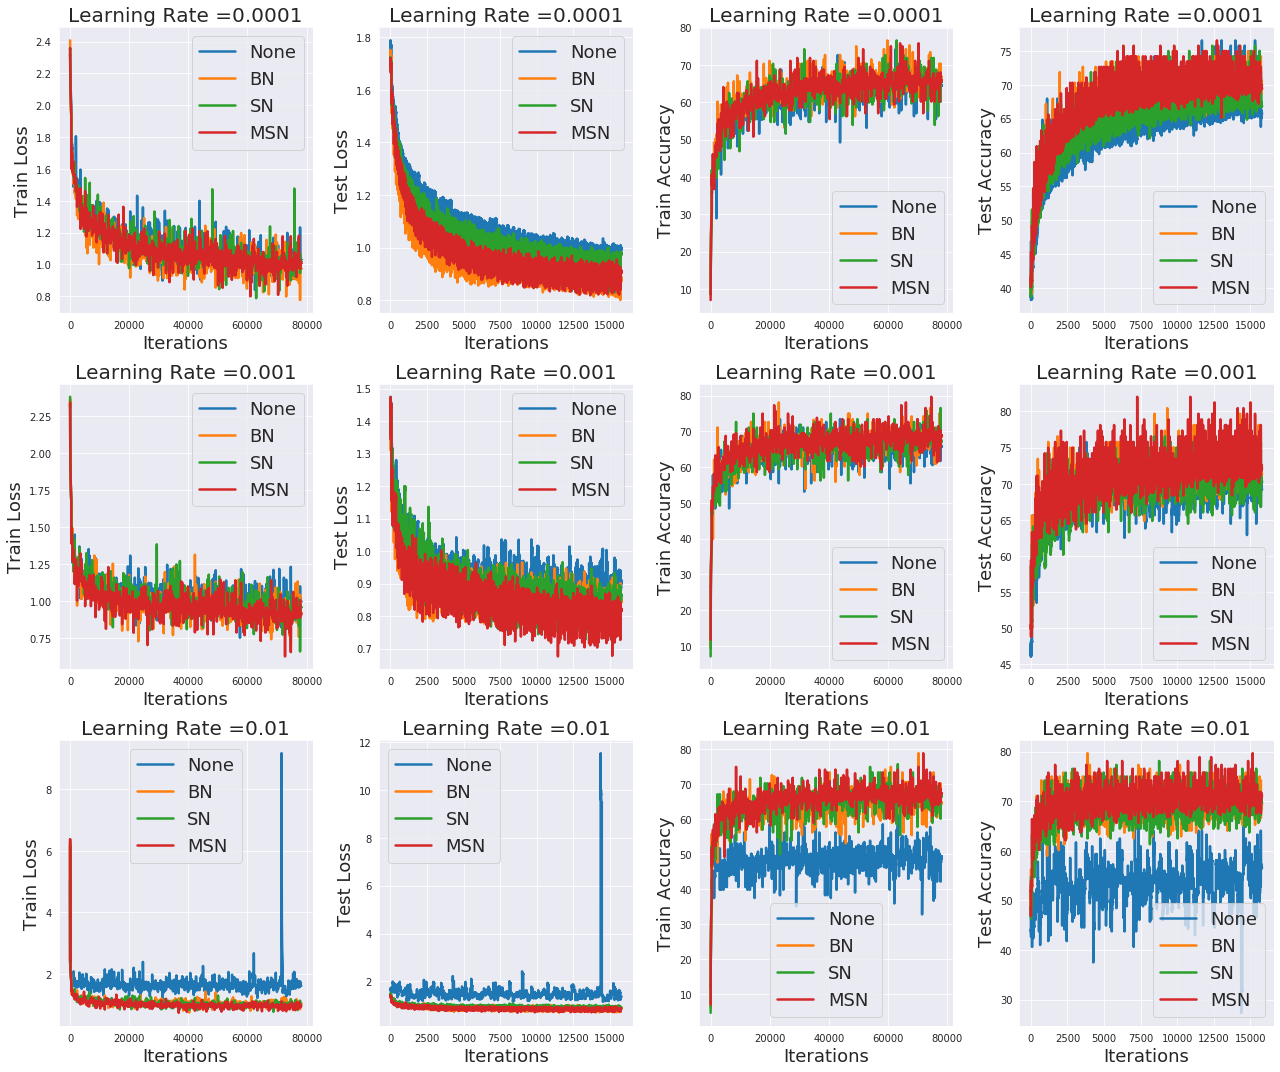

In [13]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook([None,'BN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Act_Norm_Results.pdf', dpi=400)

0
0
0


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprec

4
4
4


8
8
8



/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


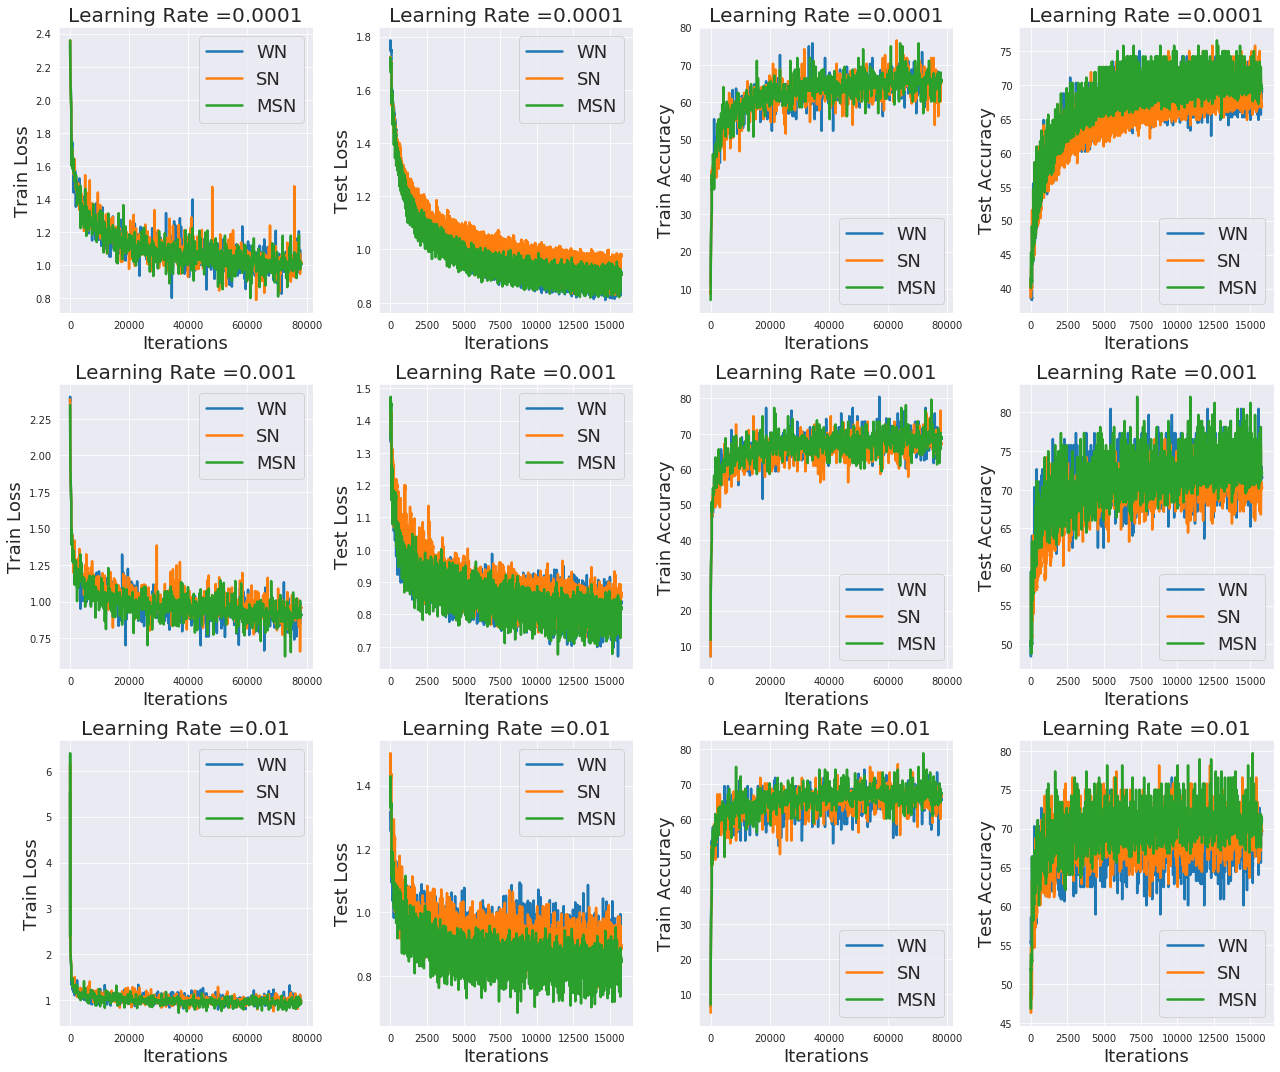

In [14]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['WN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_Results.pdf', dpi=400)

0
0


/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/robot-i9/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprec

4
4


8
8



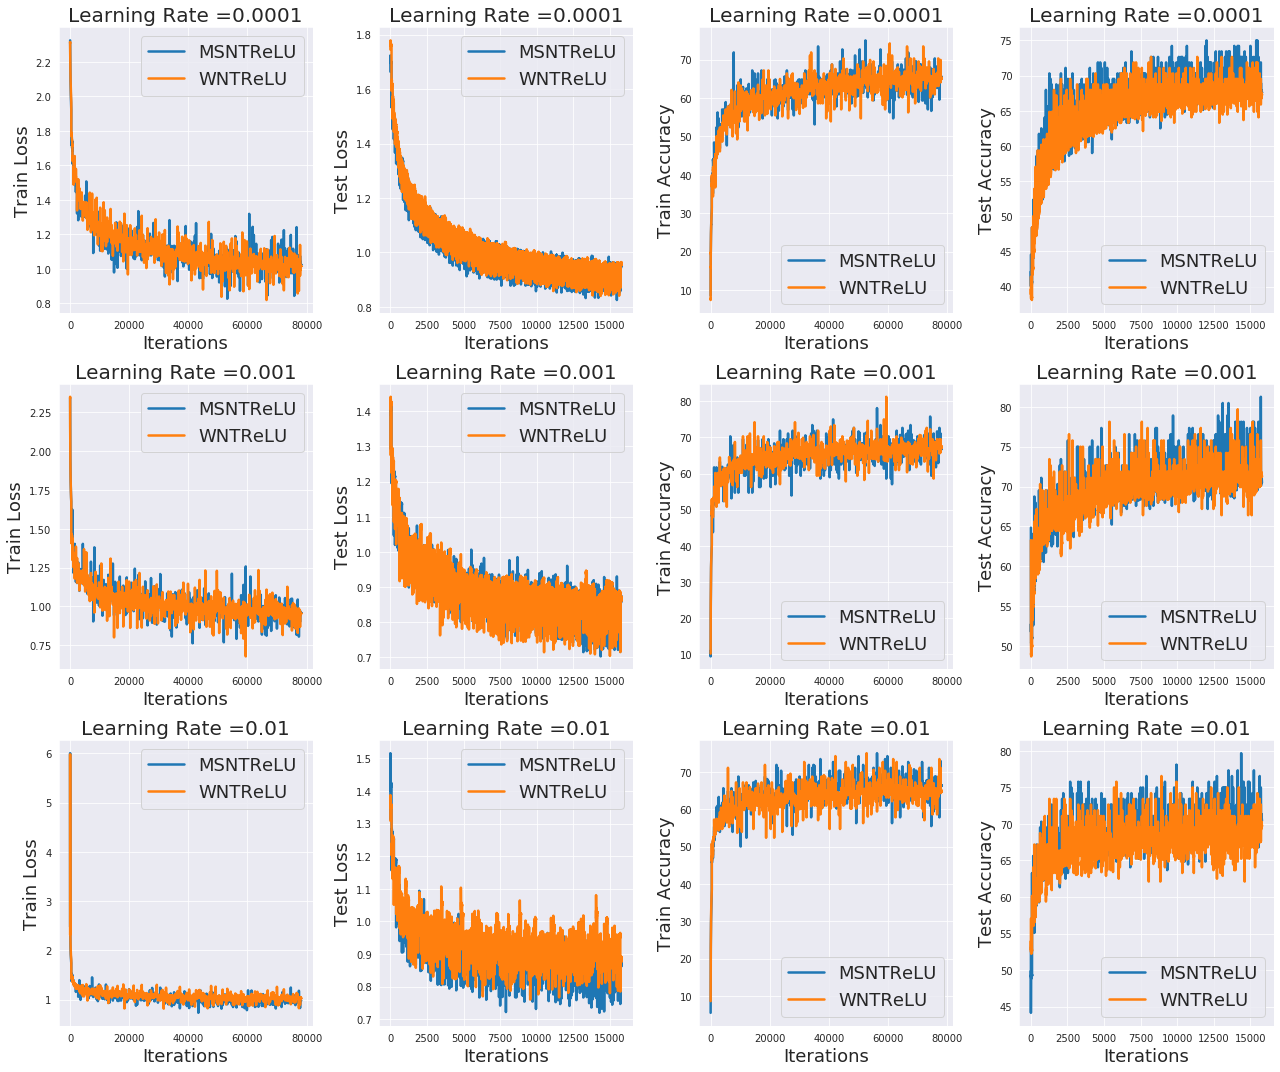

In [15]:
k = 0
plt.figure(figsize=(18, 15))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['MSNTReLU', 'WNTReLU'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"DenseNet_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"DenseNet_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"DenseNet_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"DenseNet_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(3,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(3,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(3,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_act_Results.pdf', dpi=400)